 HYBRID PIPELINE 
 STEP 1: K-FOLD (FAST GRID) 

Fold 1
 train_score: 8.963793103448568
 test_score: 49.30034482758613
 ratio: 5.499942296595312

Fold 2
 train_score: 5.7051724137933295
 test_score: 17.412758620689694
 ratio: 3.0521003324266007

Fold 3
 train_score: 5.598275862069153
 test_score: 10.723448275862042
 ratio: 1.9154912226670082

Fold 4
 train_score: 7.636551724138089
 test_score: 18.347586206896658
 ratio: 2.4026009211595416

Fold 5
 train_score: 6.88896551724137
 test_score: 34.078620689655175
 ratio: 4.946841525678253

 STEP 2: HOLDOUT (FULL GRID) 


Holdout calibration:   0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]


 STEP 3: FULL CALIBRATION 


Full calibration:   0%|          | 0/1200 [00:00<?, ?it/s]


Final parameters:
  beta_handler_patron : 0.029285714285714286
  beta_staff_staff : 0.05
  prob_food_contamination : 0.1
  contamination_size_mean : 35.0
  contamination_size_std : 30
Calibration score: 9.655172413793158


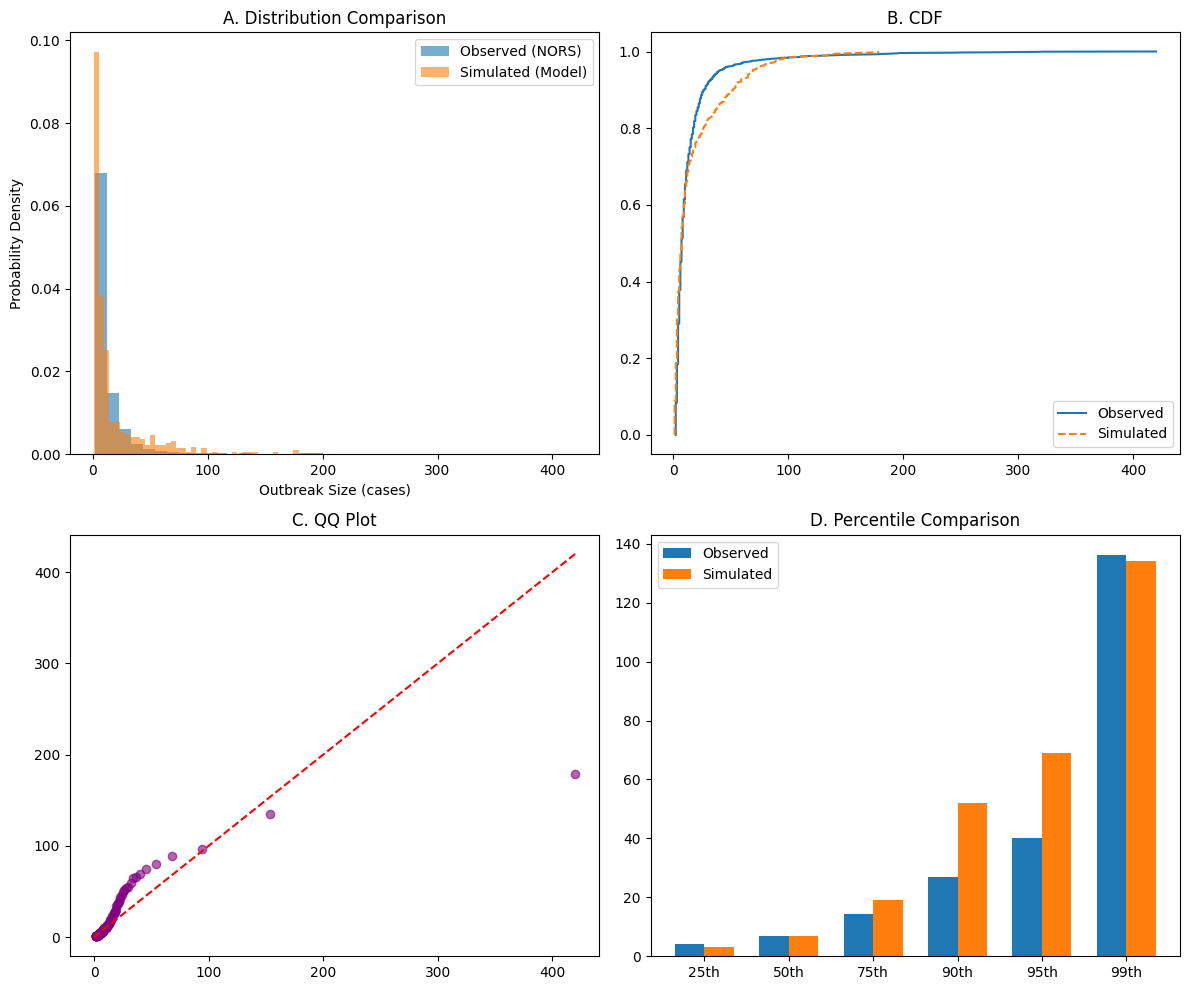

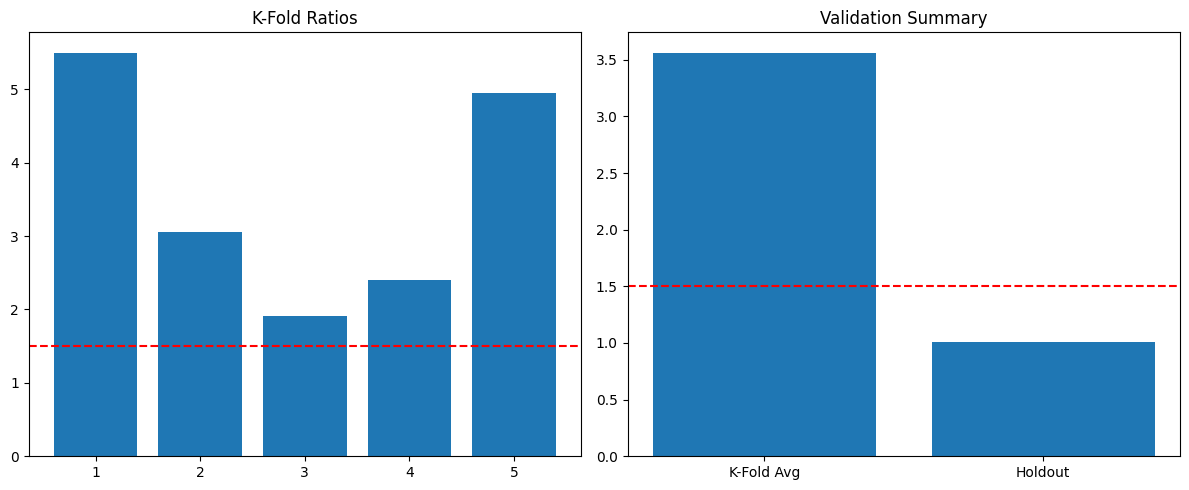


 EXTRA VALIDATION METRICS
KS statistic: 0.11765656565656565
KS p-value: 2.8300437853994425e-05
Wasserstein: 5.541575757575751
Overdispersion: 0.9512694807917121
95th pct error: 29.0
99th pct error: 2.2500000000002274
Bootstrap SD: 1.1236252905662099

Pipeline finished.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from scipy.stats import ks_2samp, wasserstein_distance


# ================================================================
#  SIMULATION MODEL  (UNCHANGED)
# ================================================================

def simulate_restaurant_outbreak_v3(
        n_food_handlers=None, n_other_staff=None, init_infected=None,
        patrons_per_shift=None, shift_hours=8, shifts_per_day=2,
        patrons_per_handler=30, max_days=5, latent_period=1.0,
        infectious_period=3.0, prob_symptomatic=0.7,
        beta_staff_staff=0.1, beta_handler_patron=0.02,
        beta_other_patron=0.001, prob_food_contamination=0.15,
        contamination_size_mean=45, contamination_size_std=30):

    if n_food_handlers is None:
        n_food_handlers = np.random.choice([3,4,5,6,7], p=[0.1,0.2,0.4,0.2,0.1])
    if n_other_staff is None:
        n_other_staff = np.random.choice([3,4,5,6], p=[0.2,0.3,0.3,0.2])
    if init_infected is None:
        init_infected = np.random.choice([1,2,3], p=[0.6,0.3,0.1])
    if patrons_per_shift is None:
        patrons_per_shift = np.random.choice([100,125,150,175,200], p=[0.2,0.2,0.3,0.2,0.1])

    total_staff = n_food_handlers + n_other_staff
    staff_states = ['S'] * total_staff
    staff_infection_day = [None] * total_staff
    is_handler = [True]*n_food_handlers + [False]*n_other_staff

    idxs = np.random.choice(total_staff, init_infected, replace=False)
    for x in idxs:
        staff_states[x] = 'E'
        staff_infection_day[x] = 0.0

    staff_inf_count = init_infected
    pat_inf = 0

    for day in range(max_days):

        for i in range(total_staff):
            if staff_states[i] == 'E':
                if (day - staff_infection_day[i]) >= latent_period:
                    if np.random.rand() < prob_symptomatic:
                        staff_states[i] = 'Is'
                    else:
                        staff_states[i] = 'Ia'

            elif staff_states[i] in ['Ia','Is']:
                if (day - staff_infection_day[i]) >= (latent_period + infectious_period):
                    staff_states[i] = 'R'

        inf_staff = []
        sus_staff = []
        for ii in range(total_staff):
            if staff_states[ii] in ['Ia','Is']:
                inf_staff.append(ii)
            elif staff_states[ii] == 'S':
                sus_staff.append(ii)

        if len(inf_staff) > 0 and len(sus_staff) > 0:
            for s in sus_staff:
                for z in inf_staff:
                    if staff_states[z] == 'Is' and np.random.rand() < 0.5:
                        continue
                    if np.random.rand() < beta_staff_staff:
                        staff_states[s] = 'E'
                        staff_infection_day[s] = day + np.random.uniform(0,1)
                        staff_inf_count += 1
                        break

        for sh in range(shifts_per_day):
            inf_handlers = []
            inf_other = []
            for i in range(total_staff):
                if staff_states[i] in ['Ia','Is']:
                    if staff_states[i]=='Is' and np.random.rand()<0.5:
                        continue
                    if is_handler[i]:
                        inf_handlers.append(i)
                    else:
                        inf_other.append(i)

            for hh in inf_handlers:
                pat_inf += np.random.binomial(patrons_per_handler, beta_handler_patron)

            if len(inf_other)>0:
                pat_inf += np.random.binomial(patrons_per_shift,
                                              beta_other_patron*len(inf_other))

            if len(inf_handlers)>0:
                if np.random.rand() < prob_food_contamination:
                    if contamination_size_mean > 0:
                        sig = np.sqrt(np.log(1+(contamination_size_std/contamination_size_mean)**2))
                        mu = np.log(contamination_size_mean) - sig**2/2
                        sizee = int(np.random.lognormal(mu, sig))
                        sizee = max(10, min(sizee, int(patrons_per_shift*0.9)))
                        pat_inf += sizee

    return staff_inf_count + pat_inf



# ================================================================
#  SCORING  (UNCHANGED)
# ================================================================

def calculate_score(real_sizes, sim_sizes):
    r = np.percentile(real_sizes, [10,25,50,75,90,95,99])
    s = np.percentile(sim_sizes,  [10,25,50,75,90,95,99])
    w = np.array([1,1.5,2.5,1.5,2,2.5,3.5])
    return np.average(np.abs(r-s), weights=w)



# ================================================================
#  FULL CALIBRATION (UNCHANGED)
# ================================================================

def calibrate_model(train_sizes, n_sims=500, desc="Calibrating full grid"):

    betas_handler = np.linspace(0.015,0.035,8)
    probs = np.linspace(0.10,0.22,6)
    means = np.linspace(35,65,5)
    betas_staff = [0.01, 0.03, 0.05, 0.1, 0.2]

    best_score = 999999
    best_params = None
    best_sim = None

    total_it = len(betas_handler)*len(probs)*len(means)*len(betas_staff)
    pbar = tqdm(total=total_it, desc=desc)

    for bh in betas_handler:
        for p in probs:
            for m in means:
                for bs in betas_staff:

                    sims = []
                    for _ in range(n_sims):
                        sims.append(simulate_restaurant_outbreak_v3(
                            beta_handler_patron=bh,
                            prob_food_contamination=p,
                            contamination_size_mean=m,
                            contamination_size_std=30,
                            beta_staff_staff=bs
                        ))
                    sims = np.array(sims)

                    sc = calculate_score(train_sizes, sims)

                    if sc < best_score:
                        best_score = sc
                        best_params = {
                            'beta_handler_patron': bh,
                            'beta_staff_staff': bs,
                            'prob_food_contamination': p,
                            'contamination_size_mean': m,
                            'contamination_size_std': 30
                        }
                        best_sim = sims

                    pbar.update(1)

    pbar.close()
    return best_params, best_sim, best_score



# ================================================================
#  FAST GRID FOR K-FOLD (UNCHANGED)
# ================================================================

def calibrate_fast_for_kfold(train_sizes):

    betas_handler = np.linspace(0.015,0.035,5)
    probs = np.linspace(0.10,0.22,4)
    means = np.linspace(35,65,3)
    betas_staff = [0.01, 0.05, 0.1, 0.2]

    best_sc = 999999
    best_par = None

    for bh in betas_handler:
        for p in probs:
            for m in means:
                for bs in betas_staff:

                    sims = []
                    for _ in range(200):
                        sims.append(simulate_restaurant_outbreak_v3(
                            beta_handler_patron=bh,
                            prob_food_contamination=p,
                            contamination_size_mean=m,
                            contamination_size_std=30,
                            beta_staff_staff=bs
                        ))
                    sims = np.array(sims)

                    sc = calculate_score(train_sizes, sims)

                    if sc < best_sc:
                        best_sc = sc
                        best_par = {
                            'beta_handler_patron': bh,
                            'prob_food_contamination': p,
                            'contamination_size_mean': m,
                            'beta_staff_staff': bs
                        }

    return best_par, best_sc



# ================================================================
#  STEP 1 — STRATIFIED K-FOLD  (*** UPDATED ***)
# ================================================================

def step1_kfold_validation(all_sizes, k=5):

    print("="*70)
    print(" STEP 1: K-FOLD (FAST GRID) ")
    print("="*70)

    # ----------------------------
    # SIMPLE STRATIFICATION LOGIC
    # ----------------------------
    # 5 bins based on outbreak size
    bins = np.percentile(all_sizes, [0,20,40,60,80,100])
    labels = np.digitize(all_sizes, bins[1:-1])

    # group indices by bin
    bin_groups = {b: [] for b in range(len(bins))}
    for i, lab in enumerate(labels):
        bin_groups[lab].append(i)

    # shuffle inside bins
    for b in bin_groups:
        np.random.shuffle(bin_groups[b])

    # build folds by taking equal segments from each bin
    folds = [[] for _ in range(k)]
    for b in bin_groups:
        group = bin_groups[b]
        size = len(group)
        seg = size // k
        for i in range(k):
            start = i*seg
            end = (i+1)*seg if i < k-1 else size
            folds[i].extend(group[start:end])

    results = []

    for fold in range(k):
        test_idx = np.array(folds[fold])
        train_idx = np.array([x for i,f in enumerate(folds) if i!=fold for x in f])

        train_vals = all_sizes[train_idx]
        test_vals  = all_sizes[test_idx]

        print("\nFold", fold+1)

        par, train_sc = calibrate_fast_for_kfold(train_vals)

        out = []
        for _ in range(200):
            out.append(simulate_restaurant_outbreak_v3(**par))
        out = np.array(out)

        test_sc = calculate_score(test_vals, out)
        ratio = test_sc/train_sc

        print(" train_score:", train_sc)
        print(" test_score:", test_sc)
        print(" ratio:", ratio)

        results.append({
            'fold': fold+1,
            'train_score': train_sc,
            'test_score': test_sc,
            'ratio': ratio,
            'params': par
        })

    pd.DataFrame(results).to_csv("step1_kfold_results.csv", index=False)

    return results, np.mean([r['ratio'] for r in results]), np.std([r['ratio'] for r in results])



# ================================================================
#  STEP 2 — HOLDOUT (UNCHANGED)
# ================================================================

def step2_holdout_validation(all_sizes):

    print("\n" + "="*70)
    print(" STEP 2: HOLDOUT (FULL GRID) ")
    print("="*70)

    np.random.seed(123)
    n_train = int(len(all_sizes)*0.8)
    shuf = np.random.permutation(len(all_sizes))

    train_vals = all_sizes[shuf[:n_train]]
    test_vals  = all_sizes[shuf[n_train:]]

    par, sim_train, train_sc = calibrate_model(train_vals, n_sims=300,
                                               desc="Holdout calibration")

    out = []
    for _ in tqdm(range(300)):
        out.append(simulate_restaurant_outbreak_v3(**par))
    out = np.array(out)

    test_sc = calculate_score(test_vals, out)
    ratio = test_sc/train_sc

    return par, sim_train, train_vals, out, test_vals, ratio



# ================================================================
#  STEP 3 — FULL CALIBRATION (UNCHANGED)
# ================================================================

def step3_full_calibration(all_sizes):

    print("\n" + "="*70)
    print(" STEP 3: FULL CALIBRATION ")
    print("="*70)

    par, sim_sizes, sc = calibrate_model(all_sizes, n_sims=500,
                                         desc="Full calibration")

    print("\nFinal parameters:")
    for kk,vv in par.items():
        print(" ", kk, ":", vv)
    print("Calibration score:", sc)

    return par, sim_sizes



# ================================================================
#  PLOTS (UNCHANGED)
# ================================================================

def create_publication_plots(obs, sim, kfold_results, holdout_ratio):

    fig, axes = plt.subplots(2,2, figsize=(12,10))
    ax1, ax2, ax3, ax4 = axes.flatten()

    ax1.hist(obs, bins=40, density=True, alpha=0.6, label="Observed (NORS)")
    ax1.hist(sim, bins=40, density=True, alpha=0.6, label="Simulated (Model)")
    ax1.set_title("A. Distribution Comparison")
    ax1.set_xlabel("Outbreak Size (cases)")
    ax1.set_ylabel("Probability Density")
    ax1.legend()

    sorted_obs = np.sort(obs)
    sorted_sim = np.sort(sim)
    ax2.plot(sorted_obs, np.linspace(0,1,len(sorted_obs)), label="Observed")
    ax2.plot(sorted_sim, np.linspace(0,1,len(sorted_sim)), linestyle="--", label="Simulated")
    ax2.set_title("B. CDF")
    ax2.legend()

    q_obs = np.percentile(obs, np.linspace(0,100,120))
    q_sim = np.percentile(sim, np.linspace(0,100,120))
    ax3.scatter(q_obs, q_sim, alpha=0.6, color="purple")
    ax3.plot([0,max(q_obs)], [0,max(q_obs)], 'r--')
    ax3.set_title("C. QQ Plot")

    pct_list = [25,50,75,90,95,99]
    obs_p = np.percentile(obs, pct_list)
    sim_p = np.percentile(sim, pct_list)
    x = np.arange(len(pct_list))
    width = 0.35
    ax4.bar(x-width/2, obs_p, width, label="Observed")
    ax4.bar(x+width/2, sim_p, width, label="Simulated")
    ax4.set_xticks(x)
    ax4.set_xticklabels([f"{p}th" for p in pct_list])
    ax4.set_title("D. Percentile Comparison")
    ax4.legend()

    plt.tight_layout()
    plt.show()

    ratios = [r["ratio"] for r in kfold_results]
    folds  = [r["fold"] for r in kfold_results]

    fig, (axA, axB) = plt.subplots(1,2, figsize=(12,5))
    axA.bar(folds, ratios)
    axA.axhline(1.5, linestyle="--", color="red")
    axA.set_title("K-Fold Ratios")

    axB.bar(["K-Fold Avg","Holdout"], [np.mean(ratios), holdout_ratio])
    axB.axhline(1.5, linestyle="--", color="red")
    axB.set_title("Validation Summary")

    plt.tight_layout()
    plt.show()



# ================================================================
#  EXTRA VALIDATION METRICS (UNCHANGED)
# ================================================================

def extra_validation_metrics(obs, sim):

    print("\n" + "="*70)
    print(" EXTRA VALIDATION METRICS")
    print("="*70)

    ks_stat, ks_p = ks_2samp(obs, sim)
    wd = wasserstein_distance(obs, sim)

    pct_list = [10,25,50,75,90,95,99]
    obs_p = np.percentile(obs, pct_list)
    sim_p = np.percentile(sim, pct_list)
    pct_err = np.abs(obs_p - sim_p)
    tail_95 = pct_err[-2]
    tail_99 = pct_err[-1]

    var_ratio = np.var(sim) / np.var(obs)

    boot = []
    for _ in range(200):
        boot.append(np.mean(np.random.choice(sim, size=len(sim), replace=True)))
    boot_std = np.std(boot)

    print("KS statistic:", ks_stat)
    print("KS p-value:", ks_p)
    print("Wasserstein:", wd)
    print("Overdispersion:", var_ratio)
    print("95th pct error:", tail_95)
    print("99th pct error:", tail_99)
    print("Bootstrap SD:", boot_std)

    return {
        "ks_stat": ks_stat,
        "ks_p": ks_p,
        "wd": wd,
        "var_ratio": var_ratio,
        "tail95": tail_95,
        "tail99": tail_99,
        "boot_sd": boot_std
    }



# ================================================================
#  MAIN PIPELINE (UNCHANGED)
# ================================================================

def main():

    print("="*70)
    print(" HYBRID PIPELINE ")
    print("="*70)

    df = pd.read_csv("NORS_JS1.csv", header=None)
    sizes = df[0].dropna().astype(int).values

    kfold_results, kmean, kstd = step1_kfold_validation(sizes)

    hold_params, sim_train, train_vals, sim_test, test_vals, hold_ratio = \
        step2_holdout_validation(sizes)

    final_params, sim_full = step3_full_calibration(sizes)

    create_publication_plots(sizes, sim_full, kfold_results, hold_ratio)

    extra_validation_metrics(sizes, sim_full)

    print("\nPipeline finished.")



if __name__ == "__main__":
    main()


policy

POLICY INTERVENTION ANALYSIS

Using calibrated parameters from validation pipeline:
  beta_handler_patron: 0.029
  beta_staff_staff: 0.05
  prob_food_contamination: 0.1
  contamination_size_mean: 35.0
  contamination_size_std: 30

POLICY 1: INFECTED WORKER EXCLUSION

Baseline: 50% of symptomatic workers stay home
Policy: Mandatory exclusion for all symptomatic workers


Exclusion policy (baseline):   0%|          | 0/1000 [00:00<?, ?it/s]

Exclusion policy (policy):   0%|          | 0/1000 [00:00<?, ?it/s]

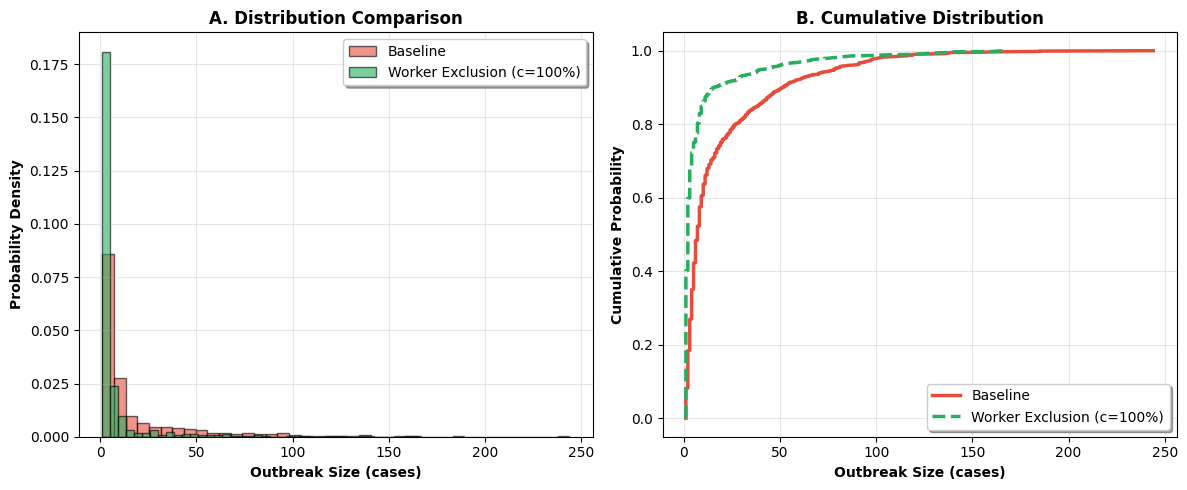


POLICY EFFECT: Worker Exclusion (compliance=100%)

Metric               Baseline        Policy          Reduction
----------------------------------------------------------------------
Mean                 18.1            8.1               54.9%
Median               7.0             2.0               71.4%
75th percentile      19.0            5.0               73.7%
90th percentile      51.1            15.1              70.5%
95th percentile      78.0            42.0              46.1%
99th percentile      119.1           119.0              0.0%
COMPLIANCE SENSITIVITY ANALYSIS

Compliance = 0%


  c=0% (baseline):   0%|          | 0/500 [00:00<?, ?it/s]

  c=0% (policy):   0%|          | 0/500 [00:00<?, ?it/s]

  Mean reduction: 17.4%
  Median reduction: 14.3%

Compliance = 25%


  c=25% (baseline):   0%|          | 0/500 [00:00<?, ?it/s]

  c=25% (policy):   0%|          | 0/500 [00:00<?, ?it/s]

  Mean reduction: 11.5%
  Median reduction: 16.7%

Compliance = 50%


  c=50% (baseline):   0%|          | 0/500 [00:00<?, ?it/s]

  c=50% (policy):   0%|          | 0/500 [00:00<?, ?it/s]

  Mean reduction: 17.7%
  Median reduction: 42.9%

Compliance = 75%


  c=75% (baseline):   0%|          | 0/500 [00:00<?, ?it/s]

  c=75% (policy):   0%|          | 0/500 [00:00<?, ?it/s]

  Mean reduction: 41.3%
  Median reduction: 57.1%

Compliance = 100%


  c=100% (baseline):   0%|          | 0/500 [00:00<?, ?it/s]

  c=100% (policy):   0%|          | 0/500 [00:00<?, ?it/s]

  Mean reduction: 62.5%
  Median reduction: 71.4%


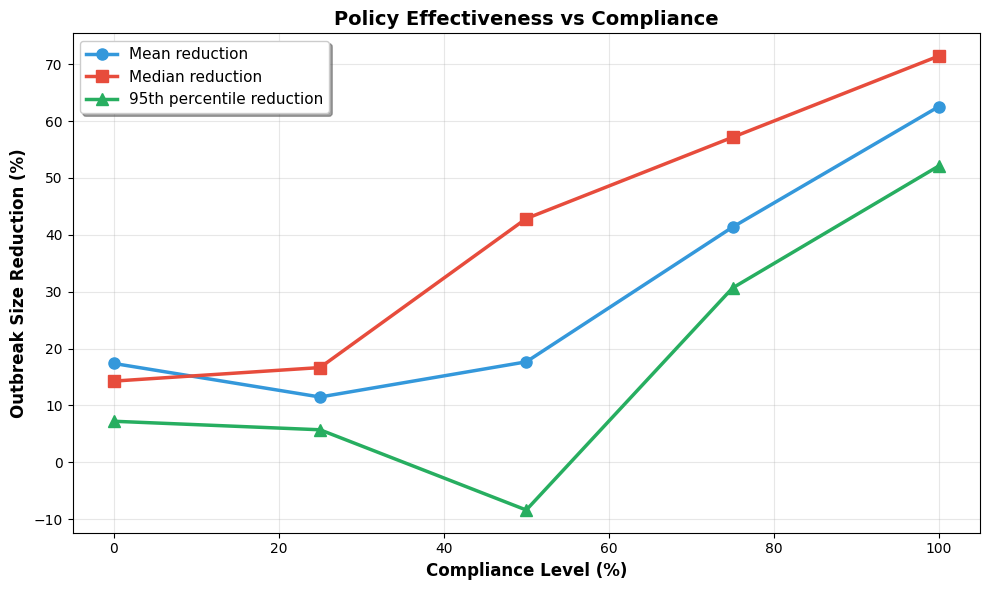


POLICY 2: HAND HYGIENE COMPLIANCE

Baseline: Standard hand hygiene
Policy: Enhanced hand hygiene (50% transmission reduction)


Hygiene policy (baseline):   0%|          | 0/1000 [00:00<?, ?it/s]

Hygiene policy (policy):   0%|          | 0/1000 [00:00<?, ?it/s]

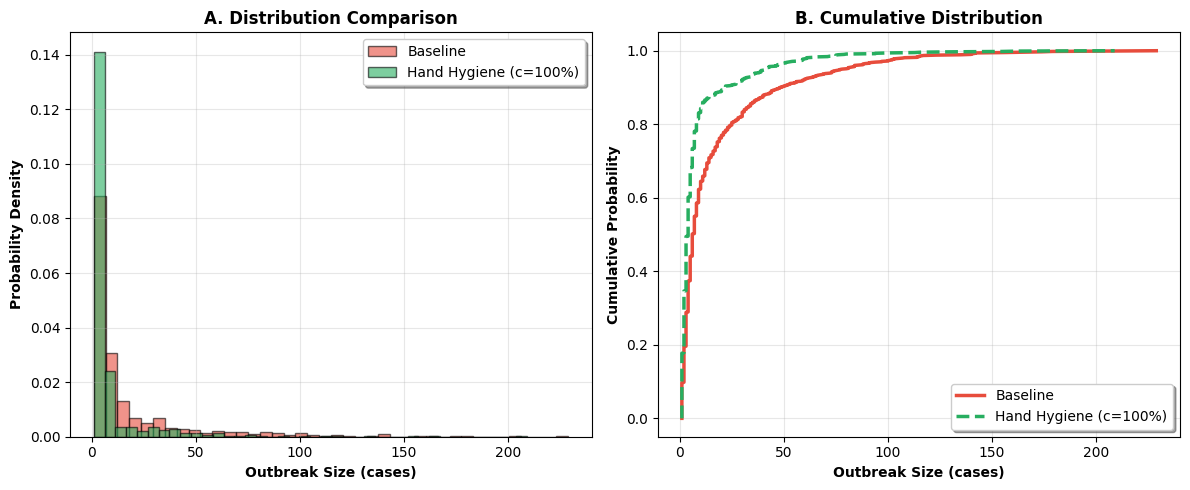


POLICY EFFECT: Hand Hygiene (compliance=100%)

Metric               Baseline        Policy          Reduction
----------------------------------------------------------------------
Mean                 17.6            8.9               49.4%
Median               6.0             4.0               33.3%
75th percentile      18.0            7.0               61.1%
90th percentile      48.1            22.0              54.3%
95th percentile      78.1            41.0              47.5%
99th percentile      140.0           79.0              43.6%
COMPLIANCE SENSITIVITY ANALYSIS

Compliance = 0%


  c=0% (baseline):   0%|          | 0/500 [00:00<?, ?it/s]

  c=0% (policy):   0%|          | 0/500 [00:00<?, ?it/s]

  Mean reduction: 5.9%
  Median reduction: 12.5%

Compliance = 25%


  c=25% (baseline):   0%|          | 0/500 [00:00<?, ?it/s]

  c=25% (policy):   0%|          | 0/500 [00:00<?, ?it/s]

  Mean reduction: 10.7%
  Median reduction: 25.0%

Compliance = 50%


  c=50% (baseline):   0%|          | 0/500 [00:00<?, ?it/s]

  c=50% (policy):   0%|          | 0/500 [00:00<?, ?it/s]

  Mean reduction: 17.1%
  Median reduction: 28.6%

Compliance = 75%


  c=75% (baseline):   0%|          | 0/500 [00:00<?, ?it/s]

  c=75% (policy):   0%|          | 0/500 [00:00<?, ?it/s]

  Mean reduction: 35.8%
  Median reduction: 42.9%

Compliance = 100%


  c=100% (baseline):   0%|          | 0/500 [00:00<?, ?it/s]

  c=100% (policy):   0%|          | 0/500 [00:00<?, ?it/s]

  Mean reduction: 53.0%
  Median reduction: 57.1%


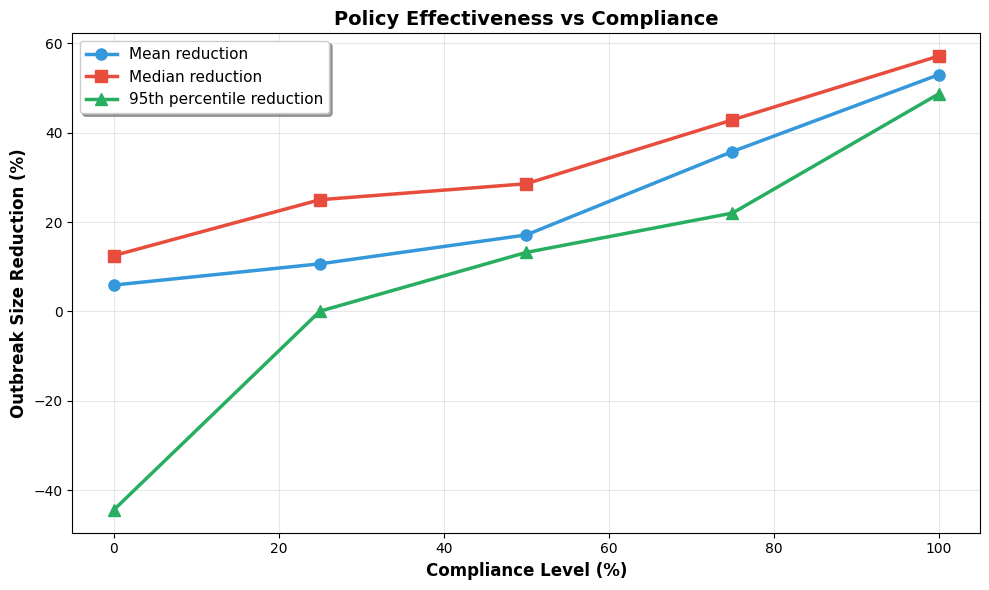


POLICY 3: COMBINED INTERVENTION

Combination of worker exclusion + hand hygiene


Combined policy (baseline):   0%|          | 0/1000 [00:00<?, ?it/s]

Combined policy (policy):   0%|          | 0/1000 [00:00<?, ?it/s]

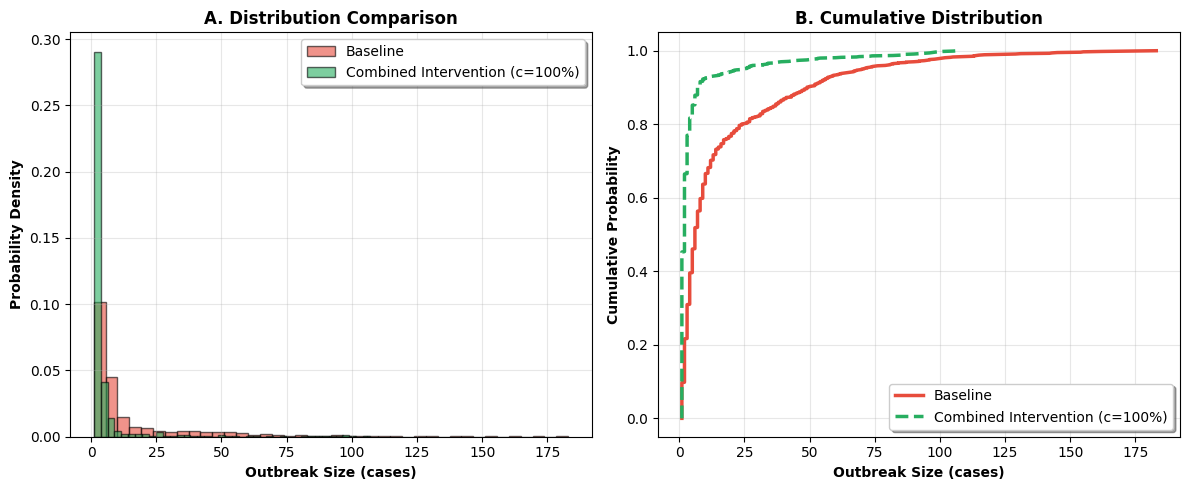


POLICY EFFECT: Combined Intervention (compliance=100%)

Metric               Baseline        Policy          Reduction
----------------------------------------------------------------------
Mean                 16.7            5.3               68.2%
Median               6.0             2.0               66.7%
75th percentile      17.0            3.0               82.4%
90th percentile      49.0            7.0               85.7%
95th percentile      70.0            25.0              64.3%
99th percentile      124.0           86.0              30.6%

POLICY COMPARISON SUMMARY

          Policy   Mean  Median  Reduction (%)
        Baseline 18.057     7.0       0.000000
Worker Exclusion  8.138     2.0      54.931605
    Hand Hygiene  8.894     4.0      49.362332
        Combined  5.325     2.0      68.172853

All results saved!

Output files:
  - exclusion_policy_comparison.png
  - hygiene_policy_comparison.png
  - combined_policy_comparison.png
  - exclusion_compliance.png
  - hygiene

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

"""
POLICY INTERVENTION MODULE

Implements and evaluates two public health interventions:
1. Infected Worker Exclusion (sick leave policy)
2. Hand Hygiene Compliance

Uses compliance factor c ∈ [0,1] to model realistic implementation.
Builds on calibrated V3 model from main pipeline.
"""

# ================================================================
#  POLICY-ENABLED SIMULATION MODEL
# ================================================================

def simulate_with_policy(
        n_food_handlers=None, n_other_staff=None, init_infected=None,
        patrons_per_shift=None, shift_hours=8, shifts_per_day=2,
        patrons_per_handler=30, max_days=5, latent_period=1.0,
        infectious_period=3.0, prob_symptomatic=0.7,
        beta_staff_staff=0.1, beta_handler_patron=0.02,
        beta_other_patron=0.001, prob_food_contamination=0.15,
        contamination_size_mean=45, contamination_size_std=30,
        # POLICY PARAMETERS
        exclusion_rate=0.0,        # ξ_max: max proportion of symptomatic staying home
        hygiene_multiplier=1.0,    # β_mult: hygiene effectiveness (1.0 = baseline)
        compliance=1.0):           # c: compliance factor [0,1]

    """
    Simulate outbreak with policy interventions.

    Policy Parameters:
    - exclusion_rate: Maximum exclusion of symptomatic workers (0 = baseline, 1 = all stay home)
    - hygiene_multiplier: Hand hygiene effectiveness (1.0 = baseline, 0.5 = 50% reduction)
    - compliance: Compliance factor [0,1] (1 = perfect, 0 = no compliance)

    Effective policies:
    - ξ_eff = compliance × exclusion_rate
    - β_eff = β × [1 - (1 - hygiene_multiplier) × compliance]
    """

    # Calculate effective policy parameters
    xi_eff = compliance * exclusion_rate

    # Hygiene reduces transmission rates
    # β_mult < 1.0 means hygiene is effective
    # β_eff = β × [1 - (1 - β_mult) × c]
    # Example: β_mult=0.5, c=1.0 → β_eff = β × 0.5 (50% reduction)
    hygiene_factor = 1 - (1 - hygiene_multiplier) * compliance

    beta_staff_eff = beta_staff_staff * hygiene_factor
    beta_handler_eff = beta_handler_patron * hygiene_factor
    beta_other_eff = beta_other_patron * hygiene_factor

    # Baseline setup (same as V3)
    if n_food_handlers is None:
        n_food_handlers = np.random.choice([3,4,5,6,7], p=[0.1,0.2,0.4,0.2,0.1])
    if n_other_staff is None:
        n_other_staff = np.random.choice([3,4,5,6], p=[0.2,0.3,0.3,0.2])
    if init_infected is None:
        init_infected = np.random.choice([1,2,3], p=[0.6,0.3,0.1])
    if patrons_per_shift is None:
        patrons_per_shift = np.random.choice([100,125,150,175,200], p=[0.2,0.2,0.3,0.2,0.1])

    total_staff = n_food_handlers + n_other_staff
    staff_states = ['S'] * total_staff
    staff_infection_day = [None] * total_staff
    is_handler = [True]*n_food_handlers + [False]*n_other_staff

    idxs = np.random.choice(total_staff, init_infected, replace=False)
    for x in idxs:
        staff_states[x] = 'E'
        staff_infection_day[x] = 0.0

    staff_inf_count = init_infected
    pat_inf = 0

    for day in range(max_days):
        # Disease progression
        for i in range(total_staff):
            if staff_states[i] == 'E':
                if (day - staff_infection_day[i]) >= latent_period:
                    if np.random.rand() < prob_symptomatic:
                        staff_states[i] = 'Is'
                    else:
                        staff_states[i] = 'Ia'
            elif staff_states[i] in ['Ia','Is']:
                if (day - staff_infection_day[i]) >= (latent_period + infectious_period):
                    staff_states[i] = 'R'

        # Staff-to-staff transmission (with hygiene policy)
        inf_staff = []
        sus_staff = []
        for ii in range(total_staff):
            if staff_states[ii] in ['Ia','Is']:
                inf_staff.append(ii)
            elif staff_states[ii] == 'S':
                sus_staff.append(ii)

        if len(inf_staff) > 0 and len(sus_staff) > 0:
            for s in sus_staff:
                for z in inf_staff:
                    # Symptomatic have baseline 50% exclusion + policy exclusion
                    if staff_states[z] == 'Is':
                        # Total exclusion probability = baseline (0.5) + policy adjustment
                        total_exclusion = 0.5 + (1 - 0.5) * xi_eff
                        if np.random.rand() < total_exclusion:
                            continue

                    # Transmission with hygiene-adjusted rate
                    if np.random.rand() < beta_staff_eff:
                        staff_states[s] = 'E'
                        staff_infection_day[s] = day + np.random.uniform(0,1)
                        staff_inf_count += 1
                        break

        # Shift-based patron transmission
        for sh in range(shifts_per_day):
            inf_handlers = []
            inf_other = []

            for i in range(total_staff):
                if staff_states[i] in ['Ia','Is']:
                    # Policy: Symptomatic exclusion
                    if staff_states[i] == 'Is':
                        total_exclusion = 0.5 + (1 - 0.5) * xi_eff
                        if np.random.rand() < total_exclusion:
                            continue

                    if is_handler[i]:
                        inf_handlers.append(i)
                    else:
                        inf_other.append(i)

            # Handler-patron transmission (with hygiene policy)
            for hh in inf_handlers:
                pat_inf += np.random.binomial(patrons_per_handler, beta_handler_eff)

            # Other staff-patron transmission (with hygiene policy)
            if len(inf_other) > 0:
                pat_inf += np.random.binomial(patrons_per_shift,
                                              beta_other_eff * len(inf_other))

            # Food contamination (hygiene affects this too)
            if len(inf_handlers) > 0:
                # Hygiene reduces contamination probability
                prob_contam_eff = prob_food_contamination * hygiene_factor

                if np.random.rand() < prob_contam_eff:
                    if contamination_size_mean > 0:
                        sig = np.sqrt(np.log(1+(contamination_size_std/contamination_size_mean)**2))
                        mu = np.log(contamination_size_mean) - sig**2/2
                        sizee = int(np.random.lognormal(mu, sig))
                        sizee = max(10, min(sizee, int(patrons_per_shift*0.9)))
                        pat_inf += sizee

    return staff_inf_count + pat_inf


# ================================================================
#  POLICY ANALYSIS FUNCTIONS
# ================================================================

def evaluate_policy(baseline_params, policy_params, n_sims=1000, desc="Policy evaluation"):
    """
    Compare baseline vs policy intervention.

    Returns:
    - baseline_sizes: array of outbreak sizes without policy
    - policy_sizes: array of outbreak sizes with policy
    - reduction: percentage reduction in mean outbreak size
    """

    baseline_sizes = []
    for _ in tqdm(range(n_sims), desc=f"{desc} (baseline)"):
        baseline_sizes.append(simulate_with_policy(**baseline_params))
    baseline_sizes = np.array(baseline_sizes)

    policy_sizes = []
    combined_params = {**baseline_params, **policy_params}
    for _ in tqdm(range(n_sims), desc=f"{desc} (policy)"):
        policy_sizes.append(simulate_with_policy(**combined_params))
    policy_sizes = np.array(policy_sizes)

    # Calculate reduction
    reduction_mean = (1 - np.mean(policy_sizes) / np.mean(baseline_sizes)) * 100
    reduction_median = (1 - np.median(policy_sizes) / np.median(baseline_sizes)) * 100
    reduction_95th = (1 - np.percentile(policy_sizes, 95) / np.percentile(baseline_sizes, 95)) * 100

    return {
        'baseline_sizes': baseline_sizes,
        'policy_sizes': policy_sizes,
        'reduction_mean': reduction_mean,
        'reduction_median': reduction_median,
        'reduction_95th': reduction_95th,
        'baseline_mean': np.mean(baseline_sizes),
        'policy_mean': np.mean(policy_sizes),
        'baseline_median': np.median(baseline_sizes),
        'policy_median': np.median(policy_sizes)
    }


def compliance_sensitivity_analysis(baseline_params, policy_params,
                                    compliance_levels=None, n_sims=500):
    """
    Test policy effectiveness across compliance levels.
    """

    if compliance_levels is None:
        compliance_levels = [0.0, 0.25, 0.50, 0.75, 1.0]

    print("="*70)
    print("COMPLIANCE SENSITIVITY ANALYSIS")
    print("="*70)

    results = []

    for c in compliance_levels:
        print(f"\nCompliance = {c:.0%}")

        policy_with_compliance = {**policy_params, 'compliance': c}

        eval_result = evaluate_policy(
            baseline_params,
            policy_with_compliance,
            n_sims=n_sims,
            desc=f"  c={c:.0%}"
        )

        results.append({
            'compliance': c,
            'reduction_mean': eval_result['reduction_mean'],
            'reduction_median': eval_result['reduction_median'],
            'reduction_95th': eval_result['reduction_95th'],
            'baseline_mean': eval_result['baseline_mean'],
            'policy_mean': eval_result['policy_mean']
        })

        print(f"  Mean reduction: {eval_result['reduction_mean']:.1f}%")
        print(f"  Median reduction: {eval_result['reduction_median']:.1f}%")

    return pd.DataFrame(results)


# ================================================================
#  VISUALIZATION FUNCTIONS
# ================================================================

def plot_policy_comparison(baseline_sizes, policy_sizes, policy_name,
                          compliance=1.0, save_prefix="policy"):
    """
    Create 2-panel comparison plot.
    """

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Panel A: Histograms
    ax1.hist(baseline_sizes, bins=40, alpha=0.6, density=True,
             label='Baseline', color='#E74C3C', edgecolor='black')
    ax1.hist(policy_sizes, bins=40, alpha=0.6, density=True,
             label=f'{policy_name} (c={compliance:.0%})',
             color='#27AE60', edgecolor='black')
    ax1.set_xlabel('Outbreak Size (cases)', fontweight='bold')
    ax1.set_ylabel('Probability Density', fontweight='bold')
    ax1.set_title('A. Distribution Comparison', fontweight='bold')
    ax1.legend(frameon=True, shadow=True)
    ax1.grid(alpha=0.3)

    # Panel B: CDFs
    ax2.plot(np.sort(baseline_sizes), np.linspace(0, 1, len(baseline_sizes)),
             linewidth=2.5, label='Baseline', color='#E74C3C')
    ax2.plot(np.sort(policy_sizes), np.linspace(0, 1, len(policy_sizes)),
             linewidth=2.5, linestyle='--',
             label=f'{policy_name} (c={compliance:.0%})', color='#27AE60')
    ax2.set_xlabel('Outbreak Size (cases)', fontweight='bold')
    ax2.set_ylabel('Cumulative Probability', fontweight='bold')
    ax2.set_title('B. Cumulative Distribution', fontweight='bold')
    ax2.legend(frameon=True, shadow=True)
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{save_prefix}_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Summary statistics
    print("\n" + "="*70)
    print(f"POLICY EFFECT: {policy_name} (compliance={compliance:.0%})")
    print("="*70)
    print(f"\n{'Metric':<20} {'Baseline':<15} {'Policy':<15} {'Reduction'}")
    print("-"*70)

    metrics = [
        ('Mean', np.mean(baseline_sizes), np.mean(policy_sizes)),
        ('Median', np.median(baseline_sizes), np.median(policy_sizes)),
        ('75th percentile', np.percentile(baseline_sizes, 75),
         np.percentile(policy_sizes, 75)),
        ('90th percentile', np.percentile(baseline_sizes, 90),
         np.percentile(policy_sizes, 90)),
        ('95th percentile', np.percentile(baseline_sizes, 95),
         np.percentile(policy_sizes, 95)),
        ('99th percentile', np.percentile(baseline_sizes, 99),
         np.percentile(policy_sizes, 99))
    ]

    for name, base_val, policy_val in metrics:
        reduction = (1 - policy_val / base_val) * 100 if base_val > 0 else 0
        print(f"{name:<20} {base_val:<15.1f} {policy_val:<15.1f} {reduction:>6.1f}%")


def plot_compliance_curves(compliance_df, save_name="compliance_curves"):
    """
    Plot reduction vs compliance level.
    """

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(compliance_df['compliance'] * 100, compliance_df['reduction_mean'],
            marker='o', linewidth=2.5, markersize=8, label='Mean reduction',
            color='#3498DB')
    ax.plot(compliance_df['compliance'] * 100, compliance_df['reduction_median'],
            marker='s', linewidth=2.5, markersize=8, label='Median reduction',
            color='#E74C3C')
    ax.plot(compliance_df['compliance'] * 100, compliance_df['reduction_95th'],
            marker='^', linewidth=2.5, markersize=8, label='95th percentile reduction',
            color='#27AE60')

    ax.set_xlabel('Compliance Level (%)', fontweight='bold', fontsize=12)
    ax.set_ylabel('Outbreak Size Reduction (%)', fontweight='bold', fontsize=12)
    ax.set_title('Policy Effectiveness vs Compliance', fontweight='bold', fontsize=14)
    ax.legend(frameon=True, shadow=True, fontsize=11)
    ax.grid(alpha=0.3)
    ax.set_xlim(-5, 105)

    plt.tight_layout()
    plt.savefig(f'{save_name}.png', dpi=300, bbox_inches='tight')
    plt.show()


# ================================================================
#  MAIN POLICY ANALYSIS WORKFLOW
# ================================================================

def run_policy_analysis(calibrated_params):
    """
    Complete policy analysis workflow.

    Input: calibrated_params from Step 3 of validation pipeline
    """

    print("="*70)
    print("POLICY INTERVENTION ANALYSIS")
    print("="*70)
    print("\nUsing calibrated parameters from validation pipeline:")
    for k, v in calibrated_params.items():
        print(f"  {k}: {v}")

    # ================================================================
    # POLICY 1: INFECTED WORKER EXCLUSION
    # ================================================================

    print("\n" + "="*70)
    print("POLICY 1: INFECTED WORKER EXCLUSION")
    print("="*70)
    print("\nBaseline: 50% of symptomatic workers stay home")
    print("Policy: Mandatory exclusion for all symptomatic workers")

    exclusion_policy = {
        'exclusion_rate': 1.0,      # 100% exclusion when compliant
        'hygiene_multiplier': 1.0,  # No hygiene change
        'compliance': 1.0           # Perfect compliance
    }

    result1 = evaluate_policy(calibrated_params, exclusion_policy, n_sims=1000,
                             desc="Exclusion policy")

    plot_policy_comparison(result1['baseline_sizes'], result1['policy_sizes'],
                          "Worker Exclusion", compliance=1.0,
                          save_prefix="exclusion_policy")

    # Compliance sensitivity for exclusion
    exclusion_compliance = compliance_sensitivity_analysis(
        calibrated_params,
        {'exclusion_rate': 1.0, 'hygiene_multiplier': 1.0},
        n_sims=500
    )
    exclusion_compliance.to_csv('exclusion_compliance_analysis.csv', index=False)
    plot_compliance_curves(exclusion_compliance, "exclusion_compliance")

    # ================================================================
    # POLICY 2: HAND HYGIENE
    # ================================================================

    print("\n" + "="*70)
    print("POLICY 2: HAND HYGIENE COMPLIANCE")
    print("="*70)
    print("\nBaseline: Standard hand hygiene")
    print("Policy: Enhanced hand hygiene (50% transmission reduction)")

    hygiene_policy = {
        'exclusion_rate': 0.0,      # No additional exclusion
        'hygiene_multiplier': 0.5,  # 50% transmission reduction
        'compliance': 1.0           # Perfect compliance
    }

    result2 = evaluate_policy(calibrated_params, hygiene_policy, n_sims=1000,
                             desc="Hygiene policy")

    plot_policy_comparison(result2['baseline_sizes'], result2['policy_sizes'],
                          "Hand Hygiene", compliance=1.0,
                          save_prefix="hygiene_policy")

    # Compliance sensitivity for hygiene
    hygiene_compliance = compliance_sensitivity_analysis(
        calibrated_params,
        {'exclusion_rate': 0.0, 'hygiene_multiplier': 0.5},
        n_sims=500
    )
    hygiene_compliance.to_csv('hygiene_compliance_analysis.csv', index=False)
    plot_compliance_curves(hygiene_compliance, "hygiene_compliance")

    # ================================================================
    # POLICY 3: COMBINED INTERVENTION
    # ================================================================

    print("\n" + "="*70)
    print("POLICY 3: COMBINED INTERVENTION")
    print("="*70)
    print("\nCombination of worker exclusion + hand hygiene")

    combined_policy = {
        'exclusion_rate': 1.0,
        'hygiene_multiplier': 0.5,
        'compliance': 1.0
    }

    result3 = evaluate_policy(calibrated_params, combined_policy, n_sims=1000,
                             desc="Combined policy")

    plot_policy_comparison(result3['baseline_sizes'], result3['policy_sizes'],
                          "Combined Intervention", compliance=1.0,
                          save_prefix="combined_policy")

    # ================================================================
    # SUMMARY TABLE
    # ================================================================

    print("\n" + "="*70)
    print("POLICY COMPARISON SUMMARY")
    print("="*70)

    summary = pd.DataFrame([
        {
            'Policy': 'Baseline',
            'Mean': result1['baseline_mean'],
            'Median': result1['baseline_median'],
            'Reduction (%)': 0.0
        },
        {
            'Policy': 'Worker Exclusion',
            'Mean': result1['policy_mean'],
            'Median': result1['policy_median'],
            'Reduction (%)': result1['reduction_mean']
        },
        {
            'Policy': 'Hand Hygiene',
            'Mean': result2['policy_mean'],
            'Median': result2['policy_median'],
            'Reduction (%)': result2['reduction_mean']
        },
        {
            'Policy': 'Combined',
            'Mean': result3['policy_mean'],
            'Median': result3['policy_median'],
            'Reduction (%)': result3['reduction_mean']
        }
    ])

    print("\n" + summary.to_string(index=False))
    summary.to_csv('policy_summary.csv', index=False)

    print("\n" + "="*70)
    print("All results saved!")
    print("="*70)
    print("\nOutput files:")
    print("  - exclusion_policy_comparison.png")
    print("  - hygiene_policy_comparison.png")
    print("  - combined_policy_comparison.png")
    print("  - exclusion_compliance.png")
    print("  - hygiene_compliance.png")
    print("  - exclusion_compliance_analysis.csv")
    print("  - hygiene_compliance_analysis.csv")
    print("  - policy_summary.csv")


# ================================================================
#  EXAMPLE USAGE
# ================================================================

if __name__ == "__main__":

    # Example: Use parameters from your calibration
    # Replace these with actual values from step3_full_calibration()

    calibrated_params = {
        'beta_handler_patron': 0.029,
        'beta_staff_staff': 0.05,
        'prob_food_contamination': 0.10,
        'contamination_size_mean': 35.0,
        'contamination_size_std': 30
    }

    # Run complete policy analysis
    run_policy_analysis(calibrated_params)


POLICY INTERVENTION ANALYSIS
RUNNING POLICY SCENARIOS

Simulations per scenario: 1500
Using calibrated parameters:
  beta_handler_patron: 0.029
  beta_staff_staff: 0.05
  prob_food_contamination: 0.1
  contamination_size_mean: 35.0
  contamination_size_std: 30

Running Baseline (A)...


Baseline:   0%|          | 0/1500 [00:00<?, ?it/s]


Running Exclusion policy (c=30%)...


Exclusion 30%:   0%|          | 0/1500 [00:00<?, ?it/s]

Running Hygiene policy (c=30%)...


Hygiene 30%:   0%|          | 0/1500 [00:00<?, ?it/s]

Running Combined policy (c=30%)...


Combined 30%:   0%|          | 0/1500 [00:00<?, ?it/s]


Running Exclusion policy (c=60%)...


Exclusion 60%:   0%|          | 0/1500 [00:00<?, ?it/s]

Running Hygiene policy (c=60%)...


Hygiene 60%:   0%|          | 0/1500 [00:00<?, ?it/s]

Running Combined policy (c=60%)...


Combined 60%:   0%|          | 0/1500 [00:00<?, ?it/s]


Running Exclusion policy (c=100%)...


Exclusion 100%:   0%|          | 0/1500 [00:00<?, ?it/s]

Running Hygiene policy (c=100%)...


Hygiene 100%:   0%|          | 0/1500 [00:00<?, ?it/s]

Running Combined policy (c=100%)...


Combined 100%:   0%|          | 0/1500 [00:00<?, ?it/s]


GENERATING SUMMARY TABLE

        Scenario Mean Median 25th pct 75th pct 95th pct Mean Reduction Median Reduction Cases Averted
      A_Baseline 16.9    7.0      3.0     16.0     71.0           0.0%             0.0%           0.0
 B_Exclusion_30% 15.3    6.0      2.0     14.0     68.0           9.3%            14.3%           1.6
   C_Hygiene_30% 15.8    6.0      3.0     14.0     68.1           6.4%            14.3%           1.1
  D_Combined_30% 14.3    5.0      2.0     13.0     65.0          15.2%            28.6%           2.6
 B_Exclusion_60% 14.5    5.0      2.0     13.0     67.0          14.3%            28.6%           2.4
   C_Hygiene_60% 14.0    5.0      3.0     12.0     62.0          16.8%            28.6%           2.8
  D_Combined_60% 11.7    4.0      2.0      9.0     54.0          30.8%            42.9%           5.2
B_Exclusion_100% 13.0    4.0      1.0     10.0     60.0          22.8%            42.9%           3.8
  C_Hygiene_100% 13.0    5.0      2.0     11.0     60.0

/tmp/ipython-input-1683305674.py:344: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=keys, patch_artist=True, showfliers=False)


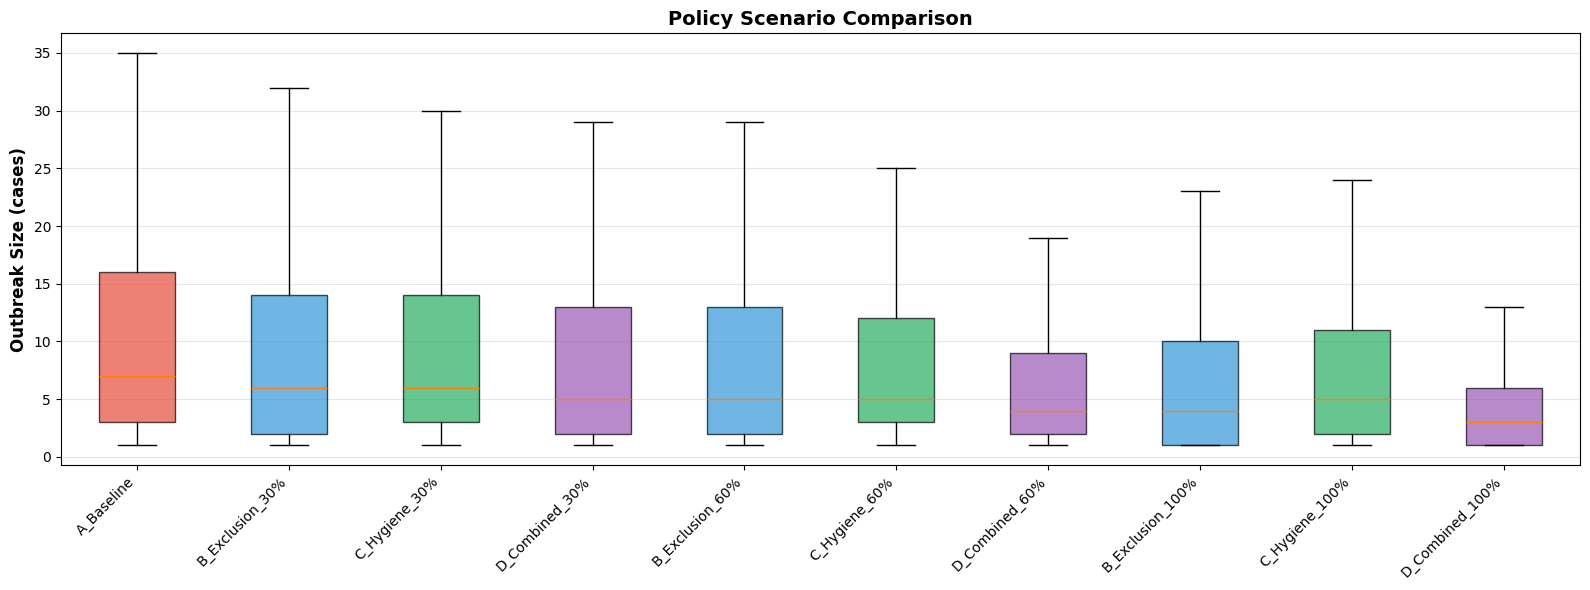

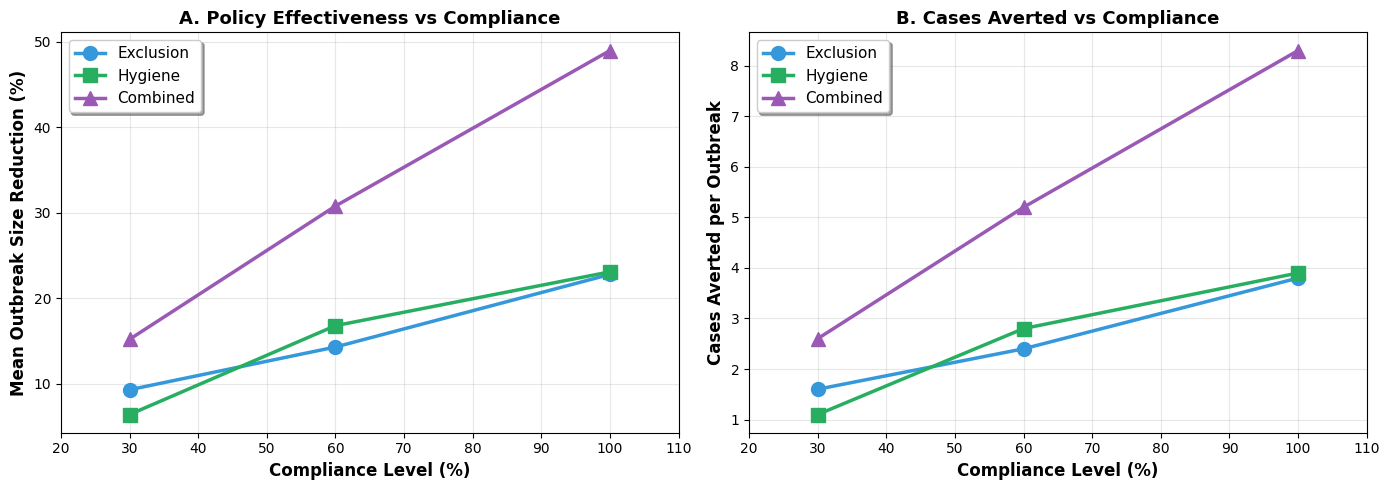


POLICY ANALYSIS COMPLETE

Output files:
  - policy_summary_table.csv
  - policy_boxplots.png
  - policy_compliance_curves.png


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

"""
ENHANCED POLICY ANALYSIS MODULE

Runs after validation pipeline to use calibrated parameters.
Tests realistic policy scenarios with compliance sensitivity.

Policies tested:
- Infected worker exclusion (with post-symptom exclusion)
- Hand hygiene improvements
- Combined interventions
- Compliance sensitivity (30%, 60%, 100%)
"""

# ============================================================
# POLICY-ENABLED SIMULATION MODEL
# ============================================================
def simulate_outbreak_policy(
    # Staff + restaurant defaults
    n_food_handlers=None,
    n_other_staff=None,
    init_infected=None,
    patrons_per_shift=None,
    patrons_per_handler=30,
    shifts_per_day=2,
    max_days=5,

    # Disease parameters
    latent_period=1.0,
    infectious_period=3.0,
    prob_symptomatic=0.7,

    # Calibrated transmission parameters (passed from validation)
    beta_staff_staff=0.1,
    beta_handler_patron=0.02,
    beta_other_patron=0.001,
    prob_food_contamination=0.15,
    contamination_size_mean=45,
    contamination_size_std=30,

    # POLICY CONTROLS
    policy_exclusion=False,    # Enable worker exclusion policy
    policy_hygiene=False,      # Enable hand hygiene policy
    compliance=0.0,            # Compliance level [0,1]
    xi_max=0.4,                # Maximum additional exclusion rate
    omega=0.2,                 # Daily return-to-work probability
    beta_mult=0.70             # Hygiene effectiveness (0.70 = 30% reduction)
):
    """
    Simulate outbreak with policy interventions.

    Policy Parameters:
    - policy_exclusion: If True, implement worker exclusion beyond baseline 50%
    - policy_hygiene: If True, improve hand hygiene practices
    - compliance: Proportion of workers complying [0,1]
    - xi_max: Maximum ADDITIONAL exclusion (beyond baseline 50%)
    - omega: Daily probability excluded worker returns (models post-symptom clearance)
    - beta_mult: Hygiene multiplier (< 1.0 means reduction)
    """

    # Sample restaurant characteristics if not specified
    if n_food_handlers is None:
        n_food_handlers = np.random.choice([3,4,5,6,7], p=[0.1,0.2,0.4,0.2,0.1])
    if n_other_staff is None:
        n_other_staff = np.random.choice([3,4,5,6], p=[0.2,0.3,0.3,0.2])
    if init_infected is None:
        init_infected = np.random.choice([1,2,3], p=[0.6,0.3,0.1])
    if patrons_per_shift is None:
        patrons_per_shift = np.random.choice([100,125,150,175,200], p=[0.2,0.2,0.3,0.2,0.1])

    # --- Apply hygiene policy ---
    if policy_hygiene:
        # β_eff = β × [1 - (1 - β_mult) × compliance]
        hygiene_factor = 1 - (1 - beta_mult) * compliance
        beta_ss_eff = beta_staff_staff * hygiene_factor
        beta_hp_eff = beta_handler_patron * hygiene_factor
        prob_contam_eff = prob_food_contamination * hygiene_factor
    else:
        beta_ss_eff = beta_staff_staff
        beta_hp_eff = beta_handler_patron
        prob_contam_eff = prob_food_contamination

    # --- Apply exclusion policy ---
    # ξ_eff = compliance × ξ_max (additional exclusion beyond baseline 50%)
    xi_eff = compliance * xi_max if policy_exclusion else 0

    # --- Initialize staff ---
    total_staff = n_food_handlers + n_other_staff
    staff_states = ['S'] * total_staff
    staff_infection_day = [None] * total_staff
    is_handler = [True]*n_food_handlers + [False]*n_other_staff
    excluded = [False] * total_staff  # Track excluded workers

    # Initial infections
    idx = np.random.choice(total_staff, init_infected, replace=False)
    for i in idx:
        staff_states[i] = 'E'
        staff_infection_day[i] = 0.0

    total_staff_inf = init_infected
    total_pat_inf = 0

    # ------------------------------------------------------------
    # MAIN SIMULATION LOOP
    # ------------------------------------------------------------
    for day in range(max_days):

        # --- Disease progression ---
        for i in range(total_staff):
            if staff_states[i] == 'E':
                if (day - staff_infection_day[i]) >= latent_period:
                    if np.random.rand() < prob_symptomatic:
                        staff_states[i] = 'Is'
                    else:
                        staff_states[i] = 'Ia'

            elif staff_states[i] in ['Ia','Is']:
                if (day - staff_infection_day[i]) >= (latent_period + infectious_period):
                    staff_states[i] = 'R'

        # --- Staff exclusion (policy-driven) ---
        if policy_exclusion:
            # Newly symptomatic workers may be excluded
            for i in range(total_staff):
                if staff_states[i] == "Is" and not excluded[i]:
                    if np.random.rand() < xi_eff:
                        excluded[i] = True

            # Excluded workers may return (models post-symptom clearance)
            for i in range(total_staff):
                if excluded[i] and np.random.rand() < omega:
                    excluded[i] = False
                    # Force recovery (simulates clearance after exclusion period)
                    staff_states[i] = 'R'

        # --- Identify infectious & susceptible workers (excluding those excluded) ---
        infectious = [
            i for i in range(total_staff)
            if staff_states[i] in ["Ia","Is"] and not excluded[i]
        ]
        susceptible = [
            i for i in range(total_staff)
            if staff_states[i] == "S" and not excluded[i]
        ]

        # --- STAFF → STAFF transmission ---
        for s in susceptible:
            for inf in infectious:
                # Baseline: symptomatic have 50% chance of staying home
                if staff_states[inf] == 'Is' and np.random.rand() < 0.5:
                    continue

                if np.random.rand() < beta_ss_eff:
                    staff_states[s] = "E"
                    staff_infection_day[s] = day + np.random.uniform(0,1)
                    total_staff_inf += 1
                    break

        # --- SHIFTS (patron transmission) ---
        for sh in range(shifts_per_day):

            # Determine who works this shift (excluding baseline + policy exclusion)
            infectious_handlers = []
            infectious_other = []

            for i in infectious:
                # Baseline: symptomatic have 50% chance of staying home
                if staff_states[i] == "Is" and np.random.rand() < 0.5:
                    continue

                if is_handler[i]:
                    infectious_handlers.append(i)
                else:
                    infectious_other.append(i)

            # --- Handler → Patron transmission ---
            for h in infectious_handlers:
                total_pat_inf += np.random.binomial(patrons_per_handler, beta_hp_eff)

            # --- Other staff → Patron transmission ---
            if len(infectious_other) > 0:
                total_pat_inf += np.random.binomial(
                    patrons_per_shift,
                    beta_other_patron * len(infectious_other)
                )

            # --- FOOD CONTAMINATION ---
            if len(infectious_handlers) > 0:
                if np.random.rand() < prob_contam_eff:
                    # Log-normal contamination size
                    sig = np.sqrt(np.log(1+(contamination_size_std/contamination_size_mean)**2))
                    mu  = np.log(contamination_size_mean) - sig**2/2
                    contam_size = int(np.random.lognormal(mu, sig))
                    contam_size = max(10, min(contam_size, int(patrons_per_shift*0.9)))
                    total_pat_inf += contam_size

    return total_staff_inf + total_pat_inf


# ============================================================
# RUN POLICY SCENARIOS
# ============================================================
def run_all_policies(calibrated_params, N_runs=1500):
    """
    Run all policy scenarios with different compliance levels.

    Scenarios:
    - A: Baseline (no policy)
    - B_*: Exclusion only (compliance 30%, 60%, 100%)
    - C_*: Hygiene only (compliance 30%, 60%, 100%)
    - D_*: Both policies (compliance 30%, 60%, 100%)
    """

    print("="*70)
    print("RUNNING POLICY SCENARIOS")
    print("="*70)
    print(f"\nSimulations per scenario: {N_runs}")
    print(f"Using calibrated parameters:")
    for k, v in calibrated_params.items():
        print(f"  {k}: {v}")
    print()

    scenarios = {}
    compliances = [0.3, 0.6, 1.0]

    # Baseline (no policy)
    print("Running Baseline (A)...")
    scenarios["A_Baseline"] = np.array([
        simulate_outbreak_policy(**calibrated_params)
        for _ in tqdm(range(N_runs), desc="Baseline")
    ])

    # Policy scenarios
    for c in compliances:
        c_pct = int(c*100)

        # Exclusion only
        print(f"\nRunning Exclusion policy (c={c_pct}%)...")
        scenarios[f"B_Exclusion_{c_pct}%"] = np.array([
            simulate_outbreak_policy(
                **calibrated_params,
                policy_exclusion=True,
                compliance=c
            ) for _ in tqdm(range(N_runs), desc=f"Exclusion {c_pct}%")
        ])

        # Hygiene only
        print(f"Running Hygiene policy (c={c_pct}%)...")
        scenarios[f"C_Hygiene_{c_pct}%"] = np.array([
            simulate_outbreak_policy(
                **calibrated_params,
                policy_hygiene=True,
                compliance=c
            ) for _ in tqdm(range(N_runs), desc=f"Hygiene {c_pct}%")
        ])

        # Both policies
        print(f"Running Combined policy (c={c_pct}%)...")
        scenarios[f"D_Combined_{c_pct}%"] = np.array([
            simulate_outbreak_policy(
                **calibrated_params,
                policy_exclusion=True,
                policy_hygiene=True,
                compliance=c
            ) for _ in tqdm(range(N_runs), desc=f"Combined {c_pct}%")
        ])

    return scenarios


# ============================================================
# SUMMARY TABLE
# ============================================================
def summarize_scenarios(scenarios):
    """
    Create summary table with key statistics.
    """

    base = scenarios["A_Baseline"]
    base_mean = np.mean(base)
    base_med = np.median(base)

    rows = []
    for k, arr in scenarios.items():
        mean_val = np.mean(arr)
        med_val = np.median(arr)
        p25 = np.percentile(arr, 25)
        p75 = np.percentile(arr, 75)
        p95 = np.percentile(arr, 95)

        # Reductions
        mean_reduc = (base_mean - mean_val) / base_mean * 100
        med_reduc = (base_med - med_val) / base_med * 100

        # Infections averted
        averted = base_mean - mean_val

        rows.append([
            k,
            f"{mean_val:.1f}",
            f"{med_val:.1f}",
            f"{p25:.1f}",
            f"{p75:.1f}",
            f"{p95:.1f}",
            f"{mean_reduc:.1f}%",
            f"{med_reduc:.1f}%",
            f"{averted:.1f}"
        ])

    df = pd.DataFrame(rows, columns=[
        "Scenario",
        "Mean",
        "Median",
        "25th pct",
        "75th pct",
        "95th pct",
        "Mean Reduction",
        "Median Reduction",
        "Cases Averted"
    ])

    return df


# ============================================================
# VISUALIZATION
# ============================================================
def plot_policy_results(scenarios, summary_df):
    """
    Create publication-quality plots.
    """

    # --- FIGURE 1: Box plots ---
    fig, ax = plt.subplots(figsize=(16, 6))

    keys = list(scenarios.keys())
    data = [scenarios[k] for k in keys]

    bp = ax.boxplot(data, labels=keys, patch_artist=True, showfliers=False)

    # Color-code by policy type
    colors = []
    for k in keys:
        if 'Baseline' in k:
            colors.append('#E74C3C')  # Red
        elif 'Exclusion' in k:
            colors.append('#3498DB')  # Blue
        elif 'Hygiene' in k:
            colors.append('#27AE60')  # Green
        elif 'Combined' in k:
            colors.append('#9B59B6')  # Purple

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_ylabel("Outbreak Size (cases)", fontweight='bold', fontsize=12)
    ax.set_title("Policy Scenario Comparison", fontweight='bold', fontsize=14)
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(keys, rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig('policy_boxplots.png', dpi=300, bbox_inches='tight')
    plt.show()

    # --- FIGURE 2: Percent reduction by compliance ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Extract reductions for each policy
    exclusion_data = []
    hygiene_data = []
    combined_data = []
    compliances = [30, 60, 100]

    for c in compliances:
        # Find matching scenarios
        excl_key = f"B_Exclusion_{c}%"
        hyg_key = f"C_Hygiene_{c}%"
        comb_key = f"D_Combined_{c}%"

        if excl_key in scenarios:
            excl_row = summary_df[summary_df['Scenario'] == excl_key]
            exclusion_data.append(float(excl_row['Mean Reduction'].values[0].rstrip('%')))

        if hyg_key in scenarios:
            hyg_row = summary_df[summary_df['Scenario'] == hyg_key]
            hygiene_data.append(float(hyg_row['Mean Reduction'].values[0].rstrip('%')))

        if comb_key in scenarios:
            comb_row = summary_df[summary_df['Scenario'] == comb_key]
            combined_data.append(float(comb_row['Mean Reduction'].values[0].rstrip('%')))

    # Panel A: Mean reduction
    ax1.plot(compliances, exclusion_data, marker='o', linewidth=2.5,
             markersize=10, label='Exclusion', color='#3498DB')
    ax1.plot(compliances, hygiene_data, marker='s', linewidth=2.5,
             markersize=10, label='Hygiene', color='#27AE60')
    ax1.plot(compliances, combined_data, marker='^', linewidth=2.5,
             markersize=10, label='Combined', color='#9B59B6')

    ax1.set_xlabel('Compliance Level (%)', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Mean Outbreak Size Reduction (%)', fontweight='bold', fontsize=12)
    ax1.set_title('A. Policy Effectiveness vs Compliance', fontweight='bold', fontsize=13)
    ax1.legend(frameon=True, shadow=True, fontsize=11)
    ax1.grid(alpha=0.3)
    ax1.set_xlim(20, 110)

    # Panel B: Cases averted
    excl_averted = []
    hyg_averted = []
    comb_averted = []

    for c in compliances:
        excl_key = f"B_Exclusion_{c}%"
        hyg_key = f"C_Hygiene_{c}%"
        comb_key = f"D_Combined_{c}%"

        if excl_key in scenarios:
            excl_row = summary_df[summary_df['Scenario'] == excl_key]
            excl_averted.append(float(excl_row['Cases Averted'].values[0]))

        if hyg_key in scenarios:
            hyg_row = summary_df[summary_df['Scenario'] == hyg_key]
            hyg_averted.append(float(hyg_row['Cases Averted'].values[0]))

        if comb_key in scenarios:
            comb_row = summary_df[summary_df['Scenario'] == comb_key]
            comb_averted.append(float(comb_row['Cases Averted'].values[0]))

    ax2.plot(compliances, excl_averted, marker='o', linewidth=2.5,
             markersize=10, label='Exclusion', color='#3498DB')
    ax2.plot(compliances, hyg_averted, marker='s', linewidth=2.5,
             markersize=10, label='Hygiene', color='#27AE60')
    ax2.plot(compliances, comb_averted, marker='^', linewidth=2.5,
             markersize=10, label='Combined', color='#9B59B6')

    ax2.set_xlabel('Compliance Level (%)', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Cases Averted per Outbreak', fontweight='bold', fontsize=12)
    ax2.set_title('B. Cases Averted vs Compliance', fontweight='bold', fontsize=13)
    ax2.legend(frameon=True, shadow=True, fontsize=11)
    ax2.grid(alpha=0.3)
    ax2.set_xlim(20, 110)

    plt.tight_layout()
    plt.savefig('policy_compliance_curves.png', dpi=300, bbox_inches='tight')
    plt.show()


# ============================================================
# MAIN WORKFLOW
# ============================================================
def run_policy_analysis(calibrated_params, n_sims=1500):
    """
    Complete policy analysis workflow.

    Input: calibrated_params from step3_full_calibration()
    """

    print("\n" + "="*70)
    print("POLICY INTERVENTION ANALYSIS")
    print("="*70)

    # Run all scenarios
    scenarios = run_all_policies(calibrated_params, N_runs=n_sims)

    # Summarize
    print("\n" + "="*70)
    print("GENERATING SUMMARY TABLE")
    print("="*70)
    summary_df = summarize_scenarios(scenarios)

    print("\n" + summary_df.to_string(index=False))
    summary_df.to_csv('policy_summary_table.csv', index=False)
    print("\n✓ Saved: policy_summary_table.csv")

    # Plot
    print("\n" + "="*70)
    print("GENERATING PLOTS")
    print("="*70)
    plot_policy_results(scenarios, summary_df)

    print("\n" + "="*70)
    print("POLICY ANALYSIS COMPLETE")
    print("="*70)
    print("\nOutput files:")
    print("  - policy_summary_table.csv")
    print("  - policy_boxplots.png")
    print("  - policy_compliance_curves.png")

    return scenarios, summary_df


# ============================================================
# EXAMPLE USAGE (run after validation pipeline)
# ============================================================
if __name__ == "__main__":

    # Example: These would come from your step3_full_calibration()
    calibrated_params = {
        'beta_handler_patron': 0.029,
        'beta_staff_staff': 0.05,
        'prob_food_contamination': 0.10,
        'contamination_size_mean': 35.0,
        'contamination_size_std': 30
    }

    # Run complete policy analysis
    scenarios, summary = run_policy_analysis(calibrated_params, n_sims=1500)














COMPREHENSIVE POLICY ANALYSIS
Testing 16 scenarios with publication-quality figures
COMPREHENSIVE POLICY ANALYSIS - 16 SCENARIOS

Simulations per scenario: 1500

Calibrated parameters:
  beta_handler_patron: 0.029
  beta_staff_staff: 0.05
  prob_food_contamination: 0.1
  contamination_size_mean: 35.0
  contamination_size_std: 30

Running A: Baseline (no intervention)...


Baseline:   0%|          | 0/1500 [00:00<?, ?it/s]

Running B: Exclusion 30% compliance...


Exclusion 30%:   0%|          | 0/1500 [00:00<?, ?it/s]

Running B: Exclusion 60% compliance...


Exclusion 60%:   0%|          | 0/1500 [00:00<?, ?it/s]

Running B: Exclusion 100% compliance...


Exclusion 100%:   0%|          | 0/1500 [00:00<?, ?it/s]

Running C: Moderate Hygiene 30% compliance...


Moderate 30%:   0%|          | 0/1500 [00:00<?, ?it/s]

Running C: Moderate Hygiene 60% compliance...


Moderate 60%:   0%|          | 0/1500 [00:00<?, ?it/s]

Running C: Moderate Hygiene 100% compliance...


Moderate 100%:   0%|          | 0/1500 [00:00<?, ?it/s]

Running C: Strict Hygiene 30% compliance...


Strict 30%:   0%|          | 0/1500 [00:00<?, ?it/s]

Running C: Strict Hygiene 60% compliance...


Strict 60%:   0%|          | 0/1500 [00:00<?, ?it/s]

Running C: Strict Hygiene 100% compliance...


Strict 100%:   0%|          | 0/1500 [00:00<?, ?it/s]

Running D: Moderate + Exclusion 30% compliance...


Moderate+Excl 30%:   0%|          | 0/1500 [00:00<?, ?it/s]

Running D: Moderate + Exclusion 60% compliance...


Moderate+Excl 60%:   0%|          | 0/1500 [00:00<?, ?it/s]

Running D: Moderate + Exclusion 100% compliance...


Moderate+Excl 100%:   0%|          | 0/1500 [00:00<?, ?it/s]

Running D: Strict + Exclusion 30% compliance...


Strict+Excl 30%:   0%|          | 0/1500 [00:00<?, ?it/s]

Running D: Strict + Exclusion 60% compliance...


Strict+Excl 60%:   0%|          | 0/1500 [00:00<?, ?it/s]

Running D: Strict + Exclusion 100% compliance...


Strict+Excl 100%:   0%|          | 0/1500 [00:00<?, ?it/s]


✓ All scenarios completed!

CREATING SUMMARY TABLE

                Scenario Mean Median  Std 25th 75th 95th Mean_Reduction_% Median_Reduction_% Cases_Averted
              A_Baseline 17.0    7.0 24.2  3.0 20.0 72.0              0.0                0.0           0.0
         B_Exclusion_30% 16.2    6.0 25.2  2.0 16.0 73.0              4.6               14.3           0.8
         B_Exclusion_60% 14.1    5.0 24.6  2.0 11.0 69.0             16.7               28.6           2.8
        B_Exclusion_100% 11.1    3.0 21.2  1.0  9.0 53.0             34.5               57.1           5.8
          C_Moderate_30% 16.7    6.0 27.4  3.0 15.0 75.0              1.6               14.3           0.3
          C_Moderate_60% 14.2    5.0 23.9  3.0 13.0 59.0             16.4               28.6           2.8
         C_Moderate_100% 11.9    5.0 20.2  2.0 10.0 53.1             29.9               28.6           5.1
            C_Strict_30% 14.7    6.0 23.3  2.0 12.0 68.1             13.6               14.

/tmp/ipython-input-3367808359.py:337: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(data_to_plot, labels=labels, patch_artist=True,


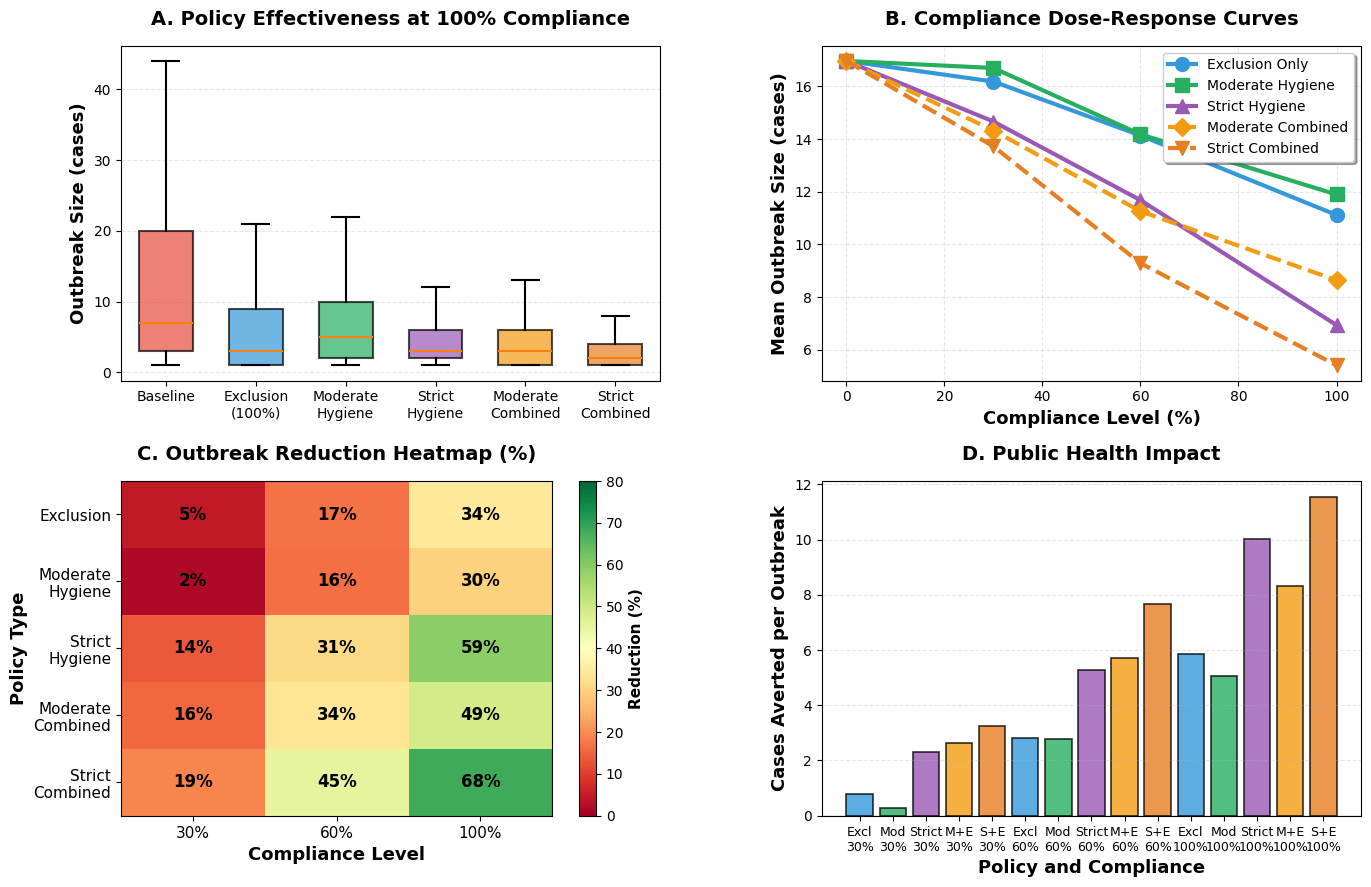

✓ Saved: Figure1_Policy_Overview.png/pdf


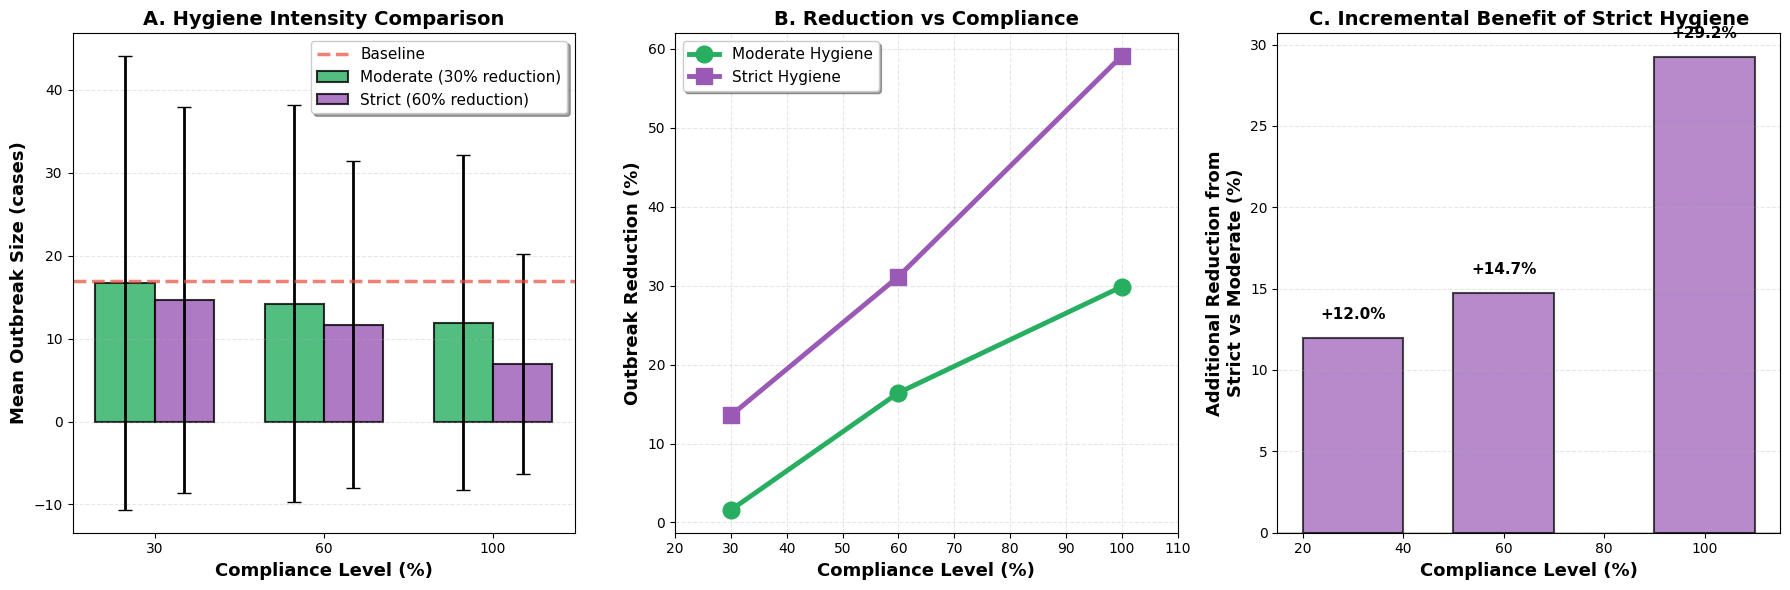

✓ Saved: Figure2_Hygiene_Comparison.png/pdf


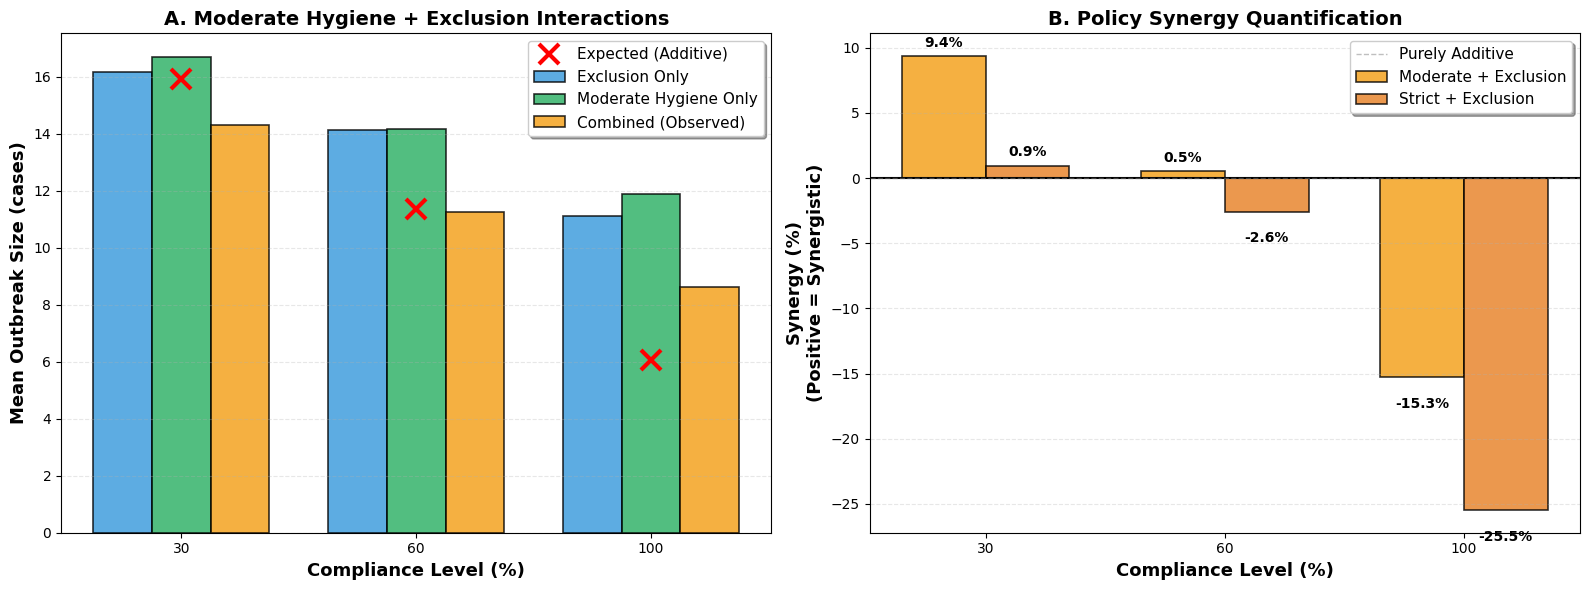

✓ Saved: Figure3_Policy_Interactions.png/pdf


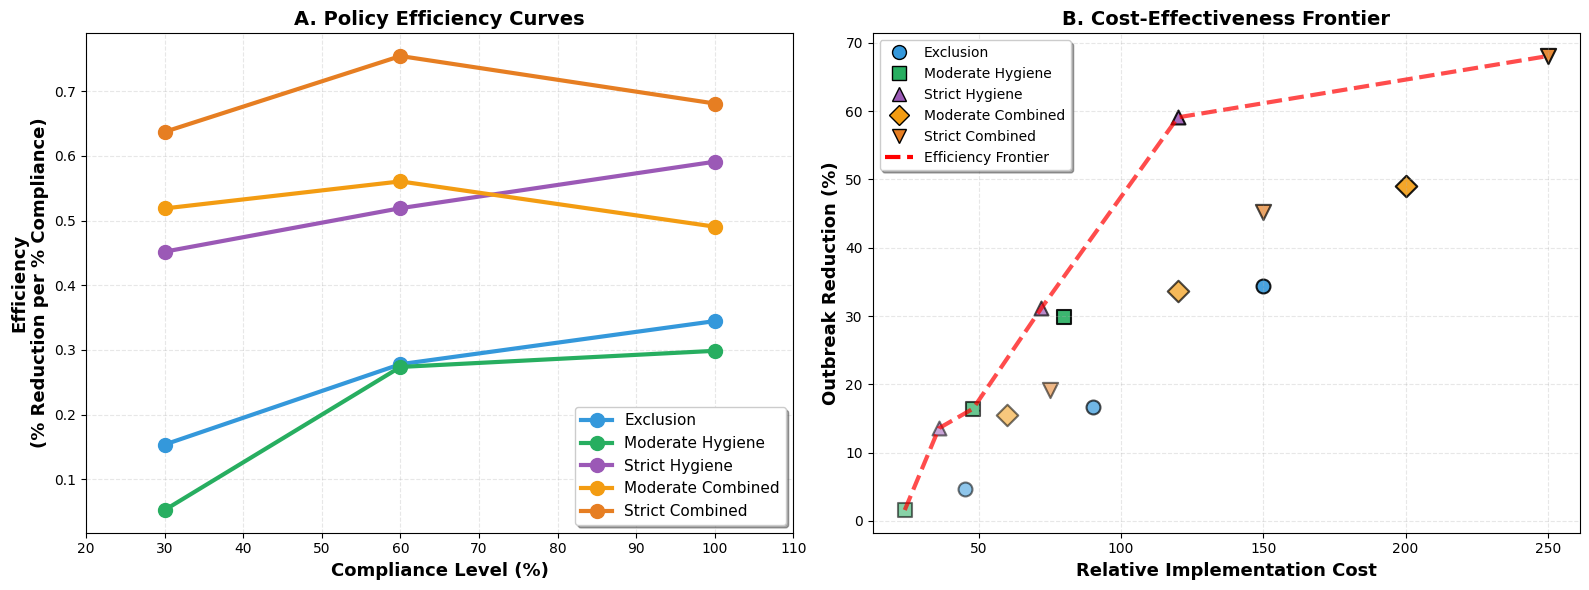

✓ Saved: Figure4_Cost_Effectiveness.png/pdf


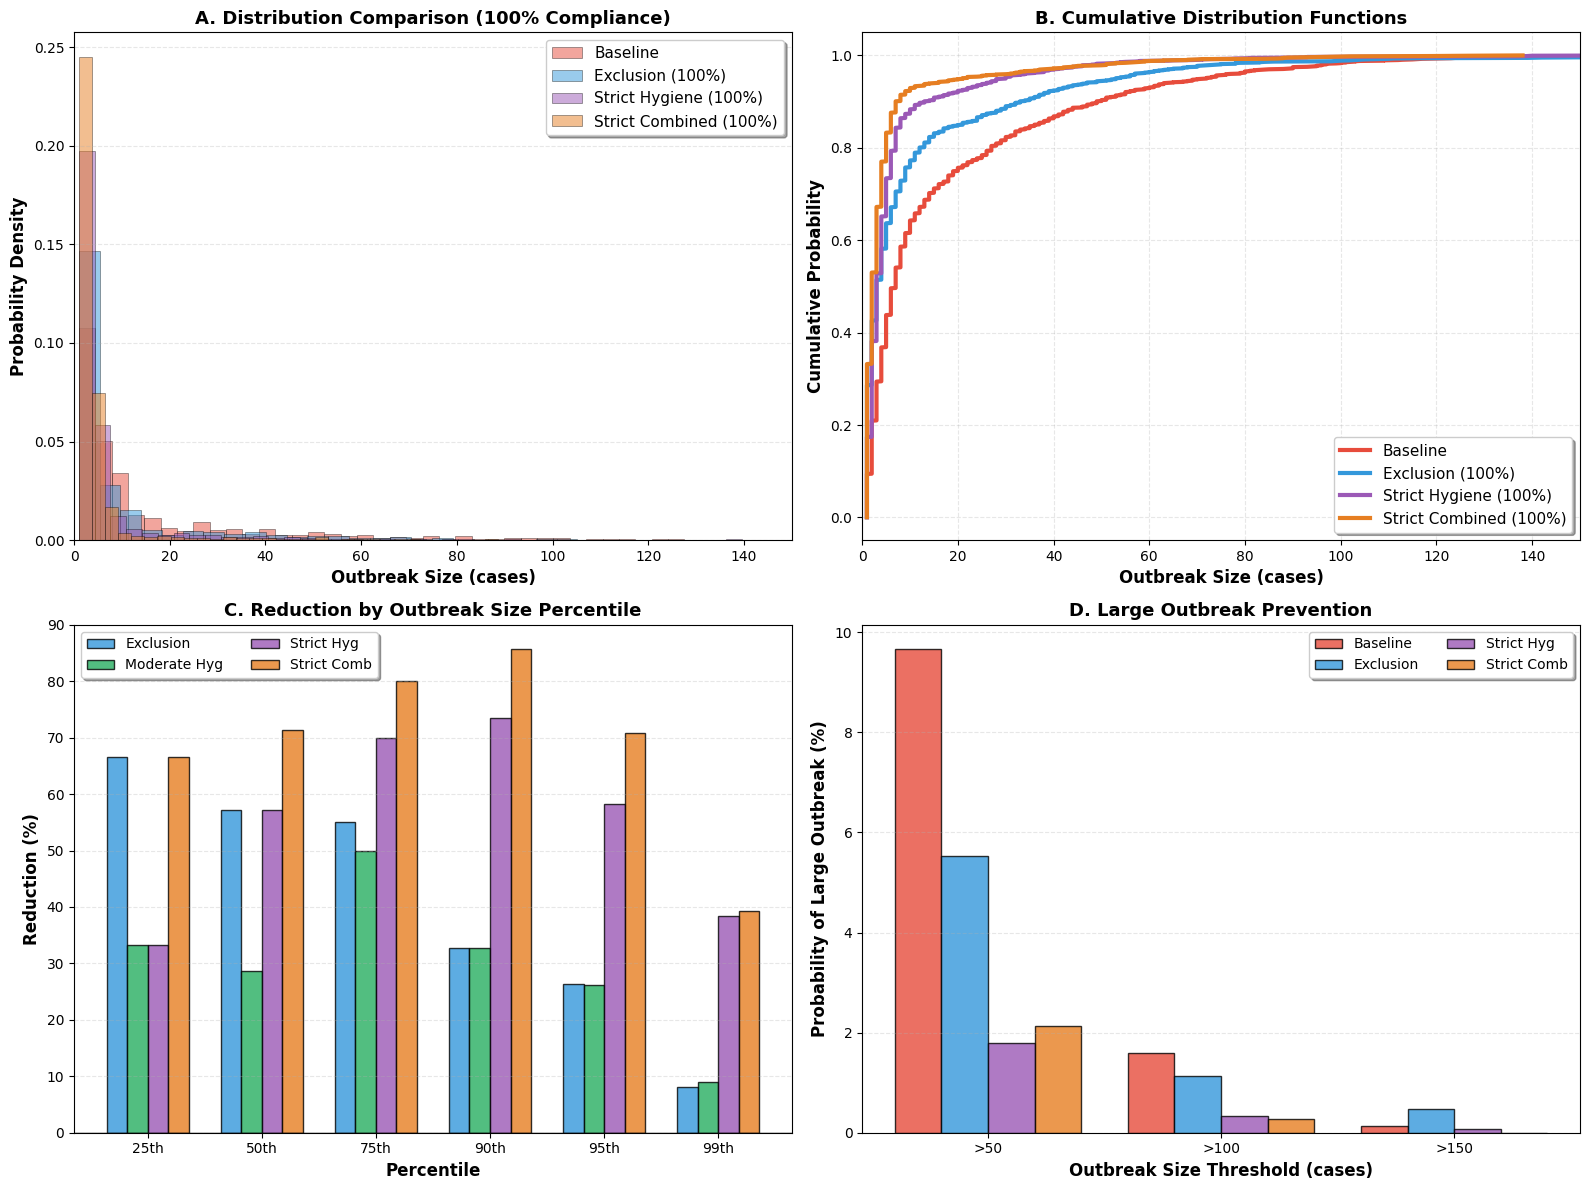

✓ Saved: Figure5_Distribution_Comparisons.png/pdf

ANALYSIS COMPLETE!

Output files:
  - Comprehensive_Policy_Summary.csv
  - Figure1_Policy_Overview.png/pdf
  - Figure2_Hygiene_Comparison.png/pdf
  - Figure3_Policy_Interactions.png/pdf
  - Figure4_Cost_Effectiveness.png/pdf
  - Figure5_Distribution_Comparisons.png/pdf



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm.notebook import tqdm
import seaborn as sns
from matplotlib.gridspec import GridSpec

"""
COMPREHENSIVE POLICY ANALYSIS WITH PUBLICATION-QUALITY FIGURES

Tests 16 scenarios:
- Baseline (no intervention)
- Exclusion only (3 compliance levels)
- Moderate hygiene (30% reduction, 3 compliance levels)
- Strict hygiene (60% reduction, 3 compliance levels)
- Moderate + Exclusion combined (3 compliance levels)
- Strict + Exclusion combined (3 compliance levels)

Produces 5 publication-quality figures for thesis/paper.
"""

# ============================================================
# POLICY-ENABLED SIMULATION MODEL
# ============================================================

def simulate_outbreak_policy(
    # Staff + restaurant defaults
    n_food_handlers=None,
    n_other_staff=None,
    init_infected=None,
    patrons_per_shift=None,
    patrons_per_handler=30,
    shifts_per_day=2,
    max_days=5,

    # Disease parameters
    latent_period=1.0,
    infectious_period=3.0,
    prob_symptomatic=0.7,

    # Calibrated transmission parameters
    beta_staff_staff=0.1,
    beta_handler_patron=0.02,
    beta_other_patron=0.001,
    prob_food_contamination=0.15,
    contamination_size_mean=45,
    contamination_size_std=30,

    # POLICY CONTROLS
    policy_exclusion=False,
    policy_hygiene=False,
    compliance=0.0,
    xi_max=0.4,
    omega=0.2,
    beta_mult=0.70
):
    """Simulate outbreak with policy interventions."""

    # Sample restaurant characteristics
    if n_food_handlers is None:
        n_food_handlers = np.random.choice([3,4,5,6,7], p=[0.1,0.2,0.4,0.2,0.1])
    if n_other_staff is None:
        n_other_staff = np.random.choice([3,4,5,6], p=[0.2,0.3,0.3,0.2])
    if init_infected is None:
        init_infected = np.random.choice([1,2,3], p=[0.6,0.3,0.1])
    if patrons_per_shift is None:
        patrons_per_shift = np.random.choice([100,125,150,175,200], p=[0.2,0.2,0.3,0.2,0.1])

    # Apply hygiene policy
    if policy_hygiene:
        hygiene_factor = 1 - (1 - beta_mult) * compliance
        beta_ss_eff = beta_staff_staff * hygiene_factor
        beta_hp_eff = beta_handler_patron * hygiene_factor
        prob_contam_eff = prob_food_contamination * hygiene_factor
    else:
        beta_ss_eff = beta_staff_staff
        beta_hp_eff = beta_handler_patron
        prob_contam_eff = prob_food_contamination

    # Apply exclusion policy
    xi_eff = compliance * xi_max if policy_exclusion else 0

    # Initialize staff
    total_staff = n_food_handlers + n_other_staff
    staff_states = ['S'] * total_staff
    staff_infection_day = [None] * total_staff
    is_handler = [True]*n_food_handlers + [False]*n_other_staff
    excluded = [False] * total_staff

    idx = np.random.choice(total_staff, init_infected, replace=False)
    for i in idx:
        staff_states[i] = 'E'
        staff_infection_day[i] = 0.0

    total_staff_inf = init_infected
    total_pat_inf = 0

    # Main simulation loop
    for day in range(max_days):

        # Disease progression
        for i in range(total_staff):
            if staff_states[i] == 'E':
                if (day - staff_infection_day[i]) >= latent_period:
                    staff_states[i] = 'Is' if np.random.rand() < prob_symptomatic else 'Ia'
            elif staff_states[i] in ['Ia','Is']:
                if (day - staff_infection_day[i]) >= (latent_period + infectious_period):
                    staff_states[i] = 'R'

        # Staff exclusion
        if policy_exclusion:
            for i in range(total_staff):
                if staff_states[i] == "Is" and not excluded[i]:
                    if np.random.rand() < xi_eff:
                        excluded[i] = True

            for i in range(total_staff):
                if excluded[i] and np.random.rand() < omega:
                    excluded[i] = False
                    staff_states[i] = 'R'

        # Identify infectious & susceptible
        infectious = [i for i in range(total_staff)
                     if staff_states[i] in ["Ia","Is"] and not excluded[i]]
        susceptible = [i for i in range(total_staff)
                      if staff_states[i] == "S" and not excluded[i]]

        # Staff-to-staff transmission
        for s in susceptible:
            for inf in infectious:
                if staff_states[inf] == 'Is' and np.random.rand() < 0.5:
                    continue
                if np.random.rand() < beta_ss_eff:
                    staff_states[s] = "E"
                    staff_infection_day[s] = day + np.random.uniform(0,1)
                    total_staff_inf += 1
                    break

        # Shifts
        for sh in range(shifts_per_day):
            infectious_handlers = []
            infectious_other = []

            for i in infectious:
                if staff_states[i] == "Is" and np.random.rand() < 0.5:
                    continue
                if is_handler[i]:
                    infectious_handlers.append(i)
                else:
                    infectious_other.append(i)

            # Handler-patron transmission
            for h in infectious_handlers:
                total_pat_inf += np.random.binomial(patrons_per_handler, beta_hp_eff)

            # Other staff-patron transmission
            if len(infectious_other) > 0:
                total_pat_inf += np.random.binomial(patrons_per_shift,
                                                    beta_other_patron * len(infectious_other))

            # Food contamination
            if len(infectious_handlers) > 0:
                if np.random.rand() < prob_contam_eff:
                    sig = np.sqrt(np.log(1+(contamination_size_std/contamination_size_mean)**2))
                    mu = np.log(contamination_size_mean) - sig**2/2
                    contam_size = int(np.random.lognormal(mu, sig))
                    contam_size = max(10, min(contam_size, int(patrons_per_shift*0.9)))
                    total_pat_inf += contam_size

    return total_staff_inf + total_pat_inf


# ============================================================
# RUN ALL 16 POLICY SCENARIOS
# ============================================================

def run_comprehensive_policy_analysis(calibrated_params, N_runs=1500):
    """
    Run complete 16-scenario policy analysis.

    Scenarios:
    A: Baseline
    B: Exclusion only (30%, 60%, 100%)
    C_Moderate: Moderate hygiene (30%, 60%, 100%)
    C_Strict: Strict hygiene (30%, 60%, 100%)
    D_Moderate: Moderate + Exclusion (30%, 60%, 100%)
    D_Strict: Strict + Exclusion (30%, 60%, 100%)
    """

    print("="*70)
    print("COMPREHENSIVE POLICY ANALYSIS - 16 SCENARIOS")
    print("="*70)
    print(f"\nSimulations per scenario: {N_runs}")
    print(f"\nCalibrated parameters:")
    for k, v in calibrated_params.items():
        print(f"  {k}: {v}")
    print()

    scenarios = {}
    compliances = [0.3, 0.6, 1.0]
    hygiene_levels = {
        'Moderate': 0.7,  # 30% transmission reduction
        'Strict': 0.4     # 60% transmission reduction
    }

    # SCENARIO A: Baseline
    print("Running A: Baseline (no intervention)...")
    scenarios["A_Baseline"] = np.array([
        simulate_outbreak_policy(**calibrated_params)
        for _ in tqdm(range(N_runs), desc="Baseline", leave=False)
    ])

    # SCENARIO B: Exclusion only
    for c in compliances:
        c_pct = int(c*100)
        print(f"Running B: Exclusion {c_pct}% compliance...")
        scenarios[f"B_Exclusion_{c_pct}%"] = np.array([
            simulate_outbreak_policy(
                **calibrated_params,
                policy_exclusion=True,
                compliance=c
            ) for _ in tqdm(range(N_runs), desc=f"Exclusion {c_pct}%", leave=False)
        ])

    # SCENARIO C: Hygiene only (Moderate + Strict)
    for hygiene_name, beta_mult in hygiene_levels.items():
        for c in compliances:
            c_pct = int(c*100)
            print(f"Running C: {hygiene_name} Hygiene {c_pct}% compliance...")
            scenarios[f"C_{hygiene_name}_{c_pct}%"] = np.array([
                simulate_outbreak_policy(
                    **calibrated_params,
                    policy_hygiene=True,
                    compliance=c,
                    beta_mult=beta_mult
                ) for _ in tqdm(range(N_runs), desc=f"{hygiene_name} {c_pct}%", leave=False)
            ])

    # SCENARIO D: Combined (Moderate + Strict)
    for hygiene_name, beta_mult in hygiene_levels.items():
        for c in compliances:
            c_pct = int(c*100)
            print(f"Running D: {hygiene_name} + Exclusion {c_pct}% compliance...")
            scenarios[f"D_{hygiene_name}_Combined_{c_pct}%"] = np.array([
                simulate_outbreak_policy(
                    **calibrated_params,
                    policy_exclusion=True,
                    policy_hygiene=True,
                    compliance=c,
                    beta_mult=beta_mult
                ) for _ in tqdm(range(N_runs), desc=f"{hygiene_name}+Excl {c_pct}%", leave=False)
            ])

    print("\n✓ All scenarios completed!")
    return scenarios


# ============================================================
# SUMMARY STATISTICS
# ============================================================

def create_summary_table(scenarios):
    """Generate comprehensive summary statistics."""

    baseline = scenarios["A_Baseline"]
    baseline_mean = np.mean(baseline)
    baseline_median = np.median(baseline)

    rows = []
    for name, data in scenarios.items():
        mean_val = np.mean(data)
        median_val = np.median(data)
        std_val = np.std(data)
        p25 = np.percentile(data, 25)
        p75 = np.percentile(data, 75)
        p95 = np.percentile(data, 95)

        mean_reduction = (baseline_mean - mean_val) / baseline_mean * 100
        median_reduction = (baseline_median - median_val) / baseline_median * 100
        cases_averted = baseline_mean - mean_val

        rows.append({
            'Scenario': name,
            'Mean': f"{mean_val:.1f}",
            'Median': f"{median_val:.1f}",
            'Std': f"{std_val:.1f}",
            '25th': f"{p25:.1f}",
            '75th': f"{p75:.1f}",
            '95th': f"{p95:.1f}",
            'Mean_Reduction_%': f"{mean_reduction:.1f}",
            'Median_Reduction_%': f"{median_reduction:.1f}",
            'Cases_Averted': f"{cases_averted:.1f}"
        })

    df = pd.DataFrame(rows)
    return df


# ============================================================
# PUBLICATION-QUALITY FIGURES
# ============================================================

def create_figure1_overview(scenarios, summary_df):
    """
    FIGURE 1: Policy Overview
    4-panel figure showing distributions and main effects
    """

    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

    # Colors
    color_baseline = '#E74C3C'
    color_exclusion = '#3498DB'
    color_moderate = '#27AE60'
    color_strict = '#9B59B6'
    color_combined_mod = '#F39C12'
    color_combined_strict = '#E67E22'

    # Panel A: Baseline vs Best of Each Policy Type
    ax1 = fig.add_subplot(gs[0, 0])

    data_to_plot = [
        scenarios['A_Baseline'],
        scenarios['B_Exclusion_100%'],
        scenarios['C_Moderate_100%'],
        scenarios['C_Strict_100%'],
        scenarios['D_Moderate_Combined_100%'],
        scenarios['D_Strict_Combined_100%']
    ]
    labels = ['Baseline', 'Exclusion\n(100%)', 'Moderate\nHygiene',
              'Strict\nHygiene', 'Moderate\nCombined', 'Strict\nCombined']
    colors = [color_baseline, color_exclusion, color_moderate,
              color_strict, color_combined_mod, color_combined_strict]

    bp = ax1.boxplot(data_to_plot, labels=labels, patch_artist=True,
                     showfliers=False, widths=0.6)

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_linewidth(1.5)

    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], linewidth=1.5)

    ax1.set_ylabel('Outbreak Size (cases)', fontweight='bold', fontsize=13)
    ax1.set_title('A. Policy Effectiveness at 100% Compliance',
                  fontweight='bold', fontsize=14, pad=15)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.set_xticklabels(labels, rotation=0, fontsize=10)

    # Panel B: Compliance Dose-Response
    ax2 = fig.add_subplot(gs[0, 1])

    compliances = [0, 30, 60, 100]

    # Exclusion
    excl_means = [
        np.mean(scenarios['A_Baseline']),
        np.mean(scenarios['B_Exclusion_30%']),
        np.mean(scenarios['B_Exclusion_60%']),
        np.mean(scenarios['B_Exclusion_100%'])
    ]

    # Moderate hygiene
    mod_means = [
        np.mean(scenarios['A_Baseline']),
        np.mean(scenarios['C_Moderate_30%']),
        np.mean(scenarios['C_Moderate_60%']),
        np.mean(scenarios['C_Moderate_100%'])
    ]

    # Strict hygiene
    strict_means = [
        np.mean(scenarios['A_Baseline']),
        np.mean(scenarios['C_Strict_30%']),
        np.mean(scenarios['C_Strict_60%']),
        np.mean(scenarios['C_Strict_100%'])
    ]

    # Combined moderate
    comb_mod_means = [
        np.mean(scenarios['A_Baseline']),
        np.mean(scenarios['D_Moderate_Combined_30%']),
        np.mean(scenarios['D_Moderate_Combined_60%']),
        np.mean(scenarios['D_Moderate_Combined_100%'])
    ]

    # Combined strict
    comb_strict_means = [
        np.mean(scenarios['A_Baseline']),
        np.mean(scenarios['D_Strict_Combined_30%']),
        np.mean(scenarios['D_Strict_Combined_60%']),
        np.mean(scenarios['D_Strict_Combined_100%'])
    ]

    ax2.plot(compliances, excl_means, marker='o', linewidth=3, markersize=10,
             label='Exclusion Only', color=color_exclusion)
    ax2.plot(compliances, mod_means, marker='s', linewidth=3, markersize=10,
             label='Moderate Hygiene', color=color_moderate)
    ax2.plot(compliances, strict_means, marker='^', linewidth=3, markersize=10,
             label='Strict Hygiene', color=color_strict)
    ax2.plot(compliances, comb_mod_means, marker='D', linewidth=3, markersize=9,
             label='Moderate Combined', color=color_combined_mod, linestyle='--')
    ax2.plot(compliances, comb_strict_means, marker='v', linewidth=3, markersize=10,
             label='Strict Combined', color=color_combined_strict, linestyle='--')

    ax2.set_xlabel('Compliance Level (%)', fontweight='bold', fontsize=13)
    ax2.set_ylabel('Mean Outbreak Size (cases)', fontweight='bold', fontsize=13)
    ax2.set_title('B. Compliance Dose-Response Curves',
                  fontweight='bold', fontsize=14, pad=15)
    ax2.legend(frameon=True, shadow=True, fontsize=10, loc='upper right')
    ax2.grid(alpha=0.3, linestyle='--')
    ax2.set_xlim(-5, 105)

    # Panel C: Percent Reduction Heatmap
    ax3 = fig.add_subplot(gs[1, 0])

    baseline_mean = np.mean(scenarios['A_Baseline'])

    # Create reduction matrix
    policies = ['Exclusion', 'Moderate\nHygiene', 'Strict\nHygiene',
                'Moderate\nCombined', 'Strict\nCombined']
    comp_levels = ['30%', '60%', '100%']

    reduction_matrix = []

    for policy_type in ['B_Exclusion', 'C_Moderate', 'C_Strict',
                        'D_Moderate_Combined', 'D_Strict_Combined']:
        row = []
        for comp in comp_levels:
            key = f"{policy_type}_{comp}"
            mean_val = np.mean(scenarios[key])
            reduction = (baseline_mean - mean_val) / baseline_mean * 100
            row.append(reduction)
        reduction_matrix.append(row)

    reduction_matrix = np.array(reduction_matrix)

    im = ax3.imshow(reduction_matrix, cmap='RdYlGn', aspect='auto',
                    vmin=0, vmax=80)

    ax3.set_xticks(np.arange(len(comp_levels)))
    ax3.set_yticks(np.arange(len(policies)))
    ax3.set_xticklabels(comp_levels, fontsize=11)
    ax3.set_yticklabels(policies, fontsize=11)

    ax3.set_xlabel('Compliance Level', fontweight='bold', fontsize=13)
    ax3.set_ylabel('Policy Type', fontweight='bold', fontsize=13)
    ax3.set_title('C. Outbreak Reduction Heatmap (%)',
                  fontweight='bold', fontsize=14, pad=15)

    # Add text annotations
    for i in range(len(policies)):
        for j in range(len(comp_levels)):
            text = ax3.text(j, i, f'{reduction_matrix[i, j]:.0f}%',
                           ha="center", va="center", color="black",
                           fontsize=12, fontweight='bold')

    cbar = plt.colorbar(im, ax=ax3)
    cbar.set_label('Reduction (%)', fontweight='bold', fontsize=11)

    # Panel D: Cases Averted
    ax4 = fig.add_subplot(gs[1, 1])

    cases_averted_data = []
    policy_labels = []
    policy_colors = []

    for comp in comp_levels:
        # Exclusion
        cases = baseline_mean - np.mean(scenarios[f'B_Exclusion_{comp}'])
        cases_averted_data.append(cases)
        policy_labels.append(f'Excl\n{comp}')
        policy_colors.append(color_exclusion)

        # Moderate
        cases = baseline_mean - np.mean(scenarios[f'C_Moderate_{comp}'])
        cases_averted_data.append(cases)
        policy_labels.append(f'Mod\n{comp}')
        policy_colors.append(color_moderate)

        # Strict
        cases = baseline_mean - np.mean(scenarios[f'C_Strict_{comp}'])
        cases_averted_data.append(cases)
        policy_labels.append(f'Strict\n{comp}')
        policy_colors.append(color_strict)

        # Mod Combined
        cases = baseline_mean - np.mean(scenarios[f'D_Moderate_Combined_{comp}'])
        cases_averted_data.append(cases)
        policy_labels.append(f'M+E\n{comp}')
        policy_colors.append(color_combined_mod)

        # Strict Combined
        cases = baseline_mean - np.mean(scenarios[f'D_Strict_Combined_{comp}'])
        cases_averted_data.append(cases)
        policy_labels.append(f'S+E\n{comp}')
        policy_colors.append(color_combined_strict)

    x_pos = np.arange(len(cases_averted_data))
    bars = ax4.bar(x_pos, cases_averted_data, color=policy_colors, alpha=0.8,
                   edgecolor='black', linewidth=1.2)

    ax4.set_xlabel('Policy and Compliance', fontweight='bold', fontsize=13)
    ax4.set_ylabel('Cases Averted per Outbreak', fontweight='bold', fontsize=13)
    ax4.set_title('D. Public Health Impact', fontweight='bold', fontsize=14, pad=15)
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(policy_labels, fontsize=9)
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

    plt.savefig('Figure1_Policy_Overview.png', dpi=300, bbox_inches='tight')
    plt.savefig('Figure1_Policy_Overview.pdf', bbox_inches='tight')
    plt.show()

    print("✓ Saved: Figure1_Policy_Overview.png/pdf")


def create_figure2_hygiene_comparison(scenarios):
    """
    FIGURE 2: Moderate vs Strict Hygiene Comparison
    Shows whether intensity or compliance matters more
    """

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    baseline_mean = np.mean(scenarios['A_Baseline'])
    compliances = [30, 60, 100]

    # Panel A: Outbreak size by hygiene intensity
    ax1 = axes[0]

    x = np.arange(len(compliances))
    width = 0.35

    moderate_means = [np.mean(scenarios[f'C_Moderate_{c}%']) for c in compliances]
    strict_means = [np.mean(scenarios[f'C_Strict_{c}%']) for c in compliances]

    moderate_std = [np.std(scenarios[f'C_Moderate_{c}%']) for c in compliances]
    strict_std = [np.std(scenarios[f'C_Strict_{c}%']) for c in compliances]

    bars1 = ax1.bar(x - width/2, moderate_means, width, label='Moderate (30% reduction)',
                    color='#27AE60', alpha=0.8, edgecolor='black', linewidth=1.5,
                    yerr=moderate_std, capsize=5, error_kw={'linewidth': 2})
    bars2 = ax1.bar(x + width/2, strict_means, width, label='Strict (60% reduction)',
                    color='#9B59B6', alpha=0.8, edgecolor='black', linewidth=1.5,
                    yerr=strict_std, capsize=5, error_kw={'linewidth': 2})

    ax1.axhline(y=baseline_mean, color='#E74C3C', linestyle='--', linewidth=2.5,
                label='Baseline', alpha=0.7)

    ax1.set_ylabel('Mean Outbreak Size (cases)', fontweight='bold', fontsize=13)
    ax1.set_xlabel('Compliance Level (%)', fontweight='bold', fontsize=13)
    ax1.set_title('A. Hygiene Intensity Comparison', fontweight='bold', fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(compliances)
    ax1.legend(frameon=True, shadow=True, fontsize=11)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')

    # Panel B: Percent reduction
    ax2 = axes[1]

    moderate_reduction = [(baseline_mean - m) / baseline_mean * 100 for m in moderate_means]
    strict_reduction = [(baseline_mean - s) / baseline_mean * 100 for s in strict_means]

    ax2.plot(compliances, moderate_reduction, marker='o', linewidth=3.5, markersize=12,
             label='Moderate Hygiene', color='#27AE60')
    ax2.plot(compliances, strict_reduction, marker='s', linewidth=3.5, markersize=12,
             label='Strict Hygiene', color='#9B59B6')

    ax2.set_ylabel('Outbreak Reduction (%)', fontweight='bold', fontsize=13)
    ax2.set_xlabel('Compliance Level (%)', fontweight='bold', fontsize=13)
    ax2.set_title('B. Reduction vs Compliance', fontweight='bold', fontsize=14)
    ax2.legend(frameon=True, shadow=True, fontsize=11)
    ax2.grid(alpha=0.3, linestyle='--')
    ax2.set_xlim(20, 110)

    # Panel C: Incremental benefit of strict over moderate
    ax3 = axes[2]

    incremental_benefit = [s - m for m, s in zip(moderate_reduction, strict_reduction)]

    bars = ax3.bar(compliances, incremental_benefit, color='#9B59B6', alpha=0.7,
                   edgecolor='black', linewidth=1.5, width=20)

    ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax3.set_ylabel('Additional Reduction from\nStrict vs Moderate (%)',
                   fontweight='bold', fontsize=13)
    ax3.set_xlabel('Compliance Level (%)', fontweight='bold', fontsize=13)
    ax3.set_title('C. Incremental Benefit of Strict Hygiene',
                  fontweight='bold', fontsize=14)
    ax3.grid(axis='y', alpha=0.3, linestyle='--')
    ax3.set_xlim(15, 115)

    # Add value labels on bars
    for bar, val in zip(bars, incremental_benefit):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'+{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.tight_layout()
    plt.savefig('Figure2_Hygiene_Comparison.png', dpi=300, bbox_inches='tight')
    plt.savefig('Figure2_Hygiene_Comparison.pdf', bbox_inches='tight')
    plt.show()

    print("✓ Saved: Figure2_Hygiene_Comparison.png/pdf")


def create_figure3_policy_interactions(scenarios):
    """
    FIGURE 3: Policy Interactions and Synergy
    Shows whether combined policies are additive, synergistic, or antagonistic
    """

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    baseline_mean = np.mean(scenarios['A_Baseline'])
    compliances = [30, 60, 100]

    # Panel A: Moderate hygiene interactions
    ax1 = axes[0]

    x = np.arange(len(compliances))
    width = 0.25

    excl_only = [np.mean(scenarios[f'B_Exclusion_{c}%']) for c in compliances]
    mod_only = [np.mean(scenarios[f'C_Moderate_{c}%']) for c in compliances]
    mod_combined = [np.mean(scenarios[f'D_Moderate_Combined_{c}%']) for c in compliances]

    # Calculate expected additive effect
    expected_additive = []
    for e, m in zip(excl_only, mod_only):
        # Expected if purely additive: combined reduction = sum of individual reductions
        excl_red = (baseline_mean - e) / baseline_mean
        mod_red = (baseline_mean - m) / baseline_mean
        expected = baseline_mean * (1 - (excl_red + mod_red))
        expected_additive.append(expected)

    bars1 = ax1.bar(x - width, excl_only, width, label='Exclusion Only',
                    color='#3498DB', alpha=0.8, edgecolor='black', linewidth=1.2)
    bars2 = ax1.bar(x, mod_only, width, label='Moderate Hygiene Only',
                    color='#27AE60', alpha=0.8, edgecolor='black', linewidth=1.2)
    bars3 = ax1.bar(x + width, mod_combined, width, label='Combined (Observed)',
                    color='#F39C12', alpha=0.8, edgecolor='black', linewidth=1.2)

    # Plot expected additive as line
    ax1.plot(x, expected_additive, marker='x', markersize=15, linewidth=0,
             color='red', label='Expected (Additive)', markeredgewidth=3)

    ax1.set_ylabel('Mean Outbreak Size (cases)', fontweight='bold', fontsize=13)
    ax1.set_xlabel('Compliance Level (%)', fontweight='bold', fontsize=13)
    ax1.set_title('A. Moderate Hygiene + Exclusion Interactions',
                  fontweight='bold', fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(compliances)
    ax1.legend(frameon=True, shadow=True, fontsize=11)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')

    # Panel B: Synergy quantification
    ax2 = axes[1]

    # Calculate synergy for both moderate and strict
    mod_synergy = []
    strict_synergy = []

    for c in compliances:
        # Moderate
        excl = np.mean(scenarios[f'B_Exclusion_{c}%'])
        mod = np.mean(scenarios[f'C_Moderate_{c}%'])
        mod_comb = np.mean(scenarios[f'D_Moderate_Combined_{c}%'])

        excl_effect = baseline_mean - excl
        mod_effect = baseline_mean - mod
        expected_additive = baseline_mean - (excl_effect + mod_effect)

        synergy = ((expected_additive - mod_comb) / baseline_mean) * 100
        mod_synergy.append(synergy)

        # Strict
        strict = np.mean(scenarios[f'C_Strict_{c}%'])
        strict_comb = np.mean(scenarios[f'D_Strict_Combined_{c}%'])

        strict_effect = baseline_mean - strict
        expected_additive_strict = baseline_mean - (excl_effect + strict_effect)

        synergy_strict = ((expected_additive_strict - strict_comb) / baseline_mean) * 100
        strict_synergy.append(synergy_strict)

    width = 0.35
    x_pos = np.arange(len(compliances))

    bars1 = ax2.bar(x_pos - width/2, mod_synergy, width, label='Moderate + Exclusion',
                    color='#F39C12', alpha=0.8, edgecolor='black', linewidth=1.2)
    bars2 = ax2.bar(x_pos + width/2, strict_synergy, width, label='Strict + Exclusion',
                    color='#E67E22', alpha=0.8, edgecolor='black', linewidth=1.2)

    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
    ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5,
                label='Purely Additive')

    ax2.set_ylabel('Synergy (%)\n(Positive = Synergistic)',
                   fontweight='bold', fontsize=13)
    ax2.set_xlabel('Compliance Level (%)', fontweight='bold', fontsize=13)
    ax2.set_title('B. Policy Synergy Quantification', fontweight='bold', fontsize=14)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(compliances)
    ax2.legend(frameon=True, shadow=True, fontsize=11)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            label_y = height + 0.5 if height > 0 else height - 1.5
            ax2.text(bar.get_x() + bar.get_width()/2., label_y,
                    f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top',
                    fontweight='bold', fontsize=10)

    plt.tight_layout()
    plt.savefig('Figure3_Policy_Interactions.png', dpi=300, bbox_inches='tight')
    plt.savefig('Figure3_Policy_Interactions.pdf', bbox_inches='tight')
    plt.show()

    print("✓ Saved: Figure3_Policy_Interactions.png/pdf")


def create_figure4_cost_effectiveness(scenarios):
    """
    FIGURE 4: Policy Efficiency Analysis
    Shows cost-effectiveness and optimal strategies
    """

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    baseline_mean = np.mean(scenarios['A_Baseline'])
    compliances = [30, 60, 100]

    # Panel A: Efficiency frontier (reduction per compliance %)
    ax1 = axes[0]

    policies = {
        'Exclusion': ('B_Exclusion', '#3498DB'),
        'Moderate Hygiene': ('C_Moderate', '#27AE60'),
        'Strict Hygiene': ('C_Strict', '#9B59B6'),
        'Moderate Combined': ('D_Moderate_Combined', '#F39C12'),
        'Strict Combined': ('D_Strict_Combined', '#E67E22')
    }

    for policy_name, (policy_key, color) in policies.items():
        reductions = []
        for c in compliances:
            mean_val = np.mean(scenarios[f'{policy_key}_{c}%'])
            reduction = (baseline_mean - mean_val) / baseline_mean * 100
            reductions.append(reduction)

        # Plot efficiency (reduction per compliance point)
        efficiency = [r/c for r, c in zip(reductions, compliances)]

        ax1.plot(compliances, efficiency, marker='o', linewidth=3, markersize=10,
                label=policy_name, color=color)

    ax1.set_xlabel('Compliance Level (%)', fontweight='bold', fontsize=13)
    ax1.set_ylabel('Efficiency\n(% Reduction per % Compliance)',
                   fontweight='bold', fontsize=13)
    ax1.set_title('A. Policy Efficiency Curves', fontweight='bold', fontsize=14)
    ax1.legend(frameon=True, shadow=True, fontsize=11)
    ax1.grid(alpha=0.3, linestyle='--')
    ax1.set_xlim(20, 110)

    # Panel B: Pareto frontier
    ax2 = axes[1]

    # Assume costs (normalized):
    # Exclusion: high compliance cost (enforcement)
    # Moderate hygiene: low compliance cost (basic training)
    # Strict hygiene: medium compliance cost (intensive training + supplies)

    cost_per_compliance = {
        'B_Exclusion': 1.5,
        'C_Moderate': 0.8,
        'C_Strict': 1.2,
        'D_Moderate_Combined': 2.0,
        'D_Strict_Combined': 2.5
    }

    all_points = []

    for policy_key, cost_factor in cost_per_compliance.items():
        for c in compliances:
            if policy_key in ['B_Exclusion', 'C_Moderate', 'C_Strict']:
                scenario_name = f'{policy_key}_{c}%'
            else:
                scenario_name = f'{policy_key}_{c}%'

            mean_val = np.mean(scenarios[scenario_name])
            reduction = (baseline_mean - mean_val) / baseline_mean * 100

            # Normalized cost = compliance * cost_factor
            cost = c * cost_factor

            all_points.append({
                'policy': scenario_name,
                'cost': cost,
                'reduction': reduction,
                'compliance': c
            })

    # Plot all points
    for point in all_points:
        policy_name = point['policy']
        if 'B_Exclusion' in policy_name:
            color, marker, size = '#3498DB', 'o', 100
        elif 'C_Moderate' in policy_name:
            color, marker, size = '#27AE60', 's', 100
        elif 'C_Strict' in policy_name and 'Combined' not in policy_name:
            color, marker, size = '#9B59B6', '^', 100
        elif 'D_Moderate' in policy_name:
            color, marker, size = '#F39C12', 'D', 120
        else:
            color, marker, size = '#E67E22', 'v', 120

        alpha = 0.4 + (point['compliance'] / 100) * 0.5

        ax2.scatter(point['cost'], point['reduction'],
                   c=color, marker=marker, s=size, alpha=alpha,
                   edgecolors='black', linewidths=1.5)

    # Find Pareto frontier
    sorted_points = sorted(all_points, key=lambda x: x['cost'])
    pareto_points = []
    max_reduction = -float('inf')

    for point in sorted_points:
        if point['reduction'] > max_reduction:
            pareto_points.append(point)
            max_reduction = point['reduction']

    # Plot Pareto frontier
    pareto_costs = [p['cost'] for p in pareto_points]
    pareto_reductions = [p['reduction'] for p in pareto_points]
    ax2.plot(pareto_costs, pareto_reductions, 'r--', linewidth=3,
             label='Efficiency Frontier', alpha=0.7)

    ax2.set_xlabel('Relative Implementation Cost', fontweight='bold', fontsize=13)
    ax2.set_ylabel('Outbreak Reduction (%)', fontweight='bold', fontsize=13)
    ax2.set_title('B. Cost-Effectiveness Frontier', fontweight='bold', fontsize=14)
    ax2.grid(alpha=0.3, linestyle='--')

    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498DB',
               markersize=10, label='Exclusion', markeredgecolor='black'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='#27AE60',
               markersize=10, label='Moderate Hygiene', markeredgecolor='black'),
        Line2D([0], [0], marker='^', color='w', markerfacecolor='#9B59B6',
               markersize=10, label='Strict Hygiene', markeredgecolor='black'),
        Line2D([0], [0], marker='D', color='w', markerfacecolor='#F39C12',
               markersize=10, label='Moderate Combined', markeredgecolor='black'),
        Line2D([0], [0], marker='v', color='w', markerfacecolor='#E67E22',
               markersize=10, label='Strict Combined', markeredgecolor='black'),
        Line2D([0], [0], color='red', linewidth=3, linestyle='--',
               label='Efficiency Frontier')
    ]
    ax2.legend(handles=legend_elements, frameon=True, shadow=True, fontsize=10)

    plt.tight_layout()
    plt.savefig('Figure4_Cost_Effectiveness.png', dpi=300, bbox_inches='tight')
    plt.savefig('Figure4_Cost_Effectiveness.pdf', bbox_inches='tight')
    plt.show()

    print("✓ Saved: Figure4_Cost_Effectiveness.png/pdf")


def create_figure5_distribution_comparisons(scenarios):
    """
    FIGURE 5: Distribution Comparisons
    Detailed distributional effects of key policies
    """

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Panel A: Baseline vs best interventions (full distributions)
    ax1 = axes[0, 0]

    policies_to_compare = [
        ('A_Baseline', 'Baseline', '#E74C3C'),
        ('B_Exclusion_100%', 'Exclusion (100%)', '#3498DB'),
        ('C_Strict_100%', 'Strict Hygiene (100%)', '#9B59B6'),
        ('D_Strict_Combined_100%', 'Strict Combined (100%)', '#E67E22')
    ]

    for key, label, color in policies_to_compare:
        data = scenarios[key]
        ax1.hist(data, bins=50, alpha=0.5, label=label, color=color,
                edgecolor='black', linewidth=0.5, density=True)

    ax1.set_xlabel('Outbreak Size (cases)', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Probability Density', fontweight='bold', fontsize=12)
    ax1.set_title('A. Distribution Comparison (100% Compliance)',
                  fontweight='bold', fontsize=13)
    ax1.legend(frameon=True, shadow=True, fontsize=11)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.set_xlim(0, 150)

    # Panel B: CDFs
    ax2 = axes[0, 1]

    for key, label, color in policies_to_compare:
        data = scenarios[key]
        sorted_data = np.sort(data)
        cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
        ax2.plot(sorted_data, cdf, label=label, color=color, linewidth=3)

    ax2.set_xlabel('Outbreak Size (cases)', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Cumulative Probability', fontweight='bold', fontsize=12)
    ax2.set_title('B. Cumulative Distribution Functions',
                  fontweight='bold', fontsize=13)
    ax2.legend(frameon=True, shadow=True, fontsize=11)
    ax2.grid(alpha=0.3, linestyle='--')
    ax2.set_xlim(0, 150)

    # Panel C: Percentile reduction across all policies
    ax3 = axes[1, 0]

    baseline = scenarios['A_Baseline']
    baseline_percentiles = np.percentile(baseline, [25, 50, 75, 90, 95, 99])

    percentile_labels = ['25th', '50th', '75th', '90th', '95th', '99th']

    # Compare key policies
    compare_policies = [
        ('B_Exclusion_100%', 'Exclusion', '#3498DB'),
        ('C_Moderate_100%', 'Moderate Hyg', '#27AE60'),
        ('C_Strict_100%', 'Strict Hyg', '#9B59B6'),
        ('D_Strict_Combined_100%', 'Strict Comb', '#E67E22')
    ]

    x = np.arange(len(percentile_labels))
    width = 0.18

    for i, (key, label, color) in enumerate(compare_policies):
        policy_percentiles = np.percentile(scenarios[key], [25, 50, 75, 90, 95, 99])
        reductions = (baseline_percentiles - policy_percentiles) / baseline_percentiles * 100

        offset = (i - 1.5) * width
        ax3.bar(x + offset, reductions, width, label=label, color=color,
               alpha=0.8, edgecolor='black', linewidth=1)

    ax3.set_ylabel('Reduction (%)', fontweight='bold', fontsize=12)
    ax3.set_xlabel('Percentile', fontweight='bold', fontsize=12)
    ax3.set_title('C. Reduction by Outbreak Size Percentile',
                  fontweight='bold', fontsize=13)
    ax3.set_xticks(x)
    ax3.set_xticklabels(percentile_labels)
    ax3.legend(frameon=True, shadow=True, fontsize=10, ncol=2)
    ax3.grid(axis='y', alpha=0.3, linestyle='--')
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)

    # Panel D: Tail prevention (>50 cases, >100 cases)
    ax4 = axes[1, 1]

    thresholds = [50, 100, 150]
    threshold_labels = ['>50', '>100', '>150']

    policies_for_tail = [
        ('A_Baseline', 'Baseline', '#E74C3C'),
        ('B_Exclusion_100%', 'Exclusion', '#3498DB'),
        ('C_Strict_100%', 'Strict Hyg', '#9B59B6'),
        ('D_Strict_Combined_100%', 'Strict Comb', '#E67E22')
    ]

    x = np.arange(len(threshold_labels))
    width = 0.2

    for i, (key, label, color) in enumerate(policies_for_tail):
        data = scenarios[key]
        percentages = []
        for threshold in thresholds:
            pct = (np.sum(data > threshold) / len(data)) * 100
            percentages.append(pct)

        offset = (i - 1.5) * width
        ax4.bar(x + offset, percentages, width, label=label, color=color,
               alpha=0.8, edgecolor='black', linewidth=1)

    ax4.set_ylabel('Probability of Large Outbreak (%)', fontweight='bold', fontsize=12)
    ax4.set_xlabel('Outbreak Size Threshold (cases)', fontweight='bold', fontsize=12)
    ax4.set_title('D. Large Outbreak Prevention', fontweight='bold', fontsize=13)
    ax4.set_xticks(x)
    ax4.set_xticklabels(threshold_labels)
    ax4.legend(frameon=True, shadow=True, fontsize=10, ncol=2)
    ax4.grid(axis='y', alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.savefig('Figure5_Distribution_Comparisons.png', dpi=300, bbox_inches='tight')
    plt.savefig('Figure5_Distribution_Comparisons.pdf', bbox_inches='tight')
    plt.show()

    print("✓ Saved: Figure5_Distribution_Comparisons.png/pdf")


# ============================================================
# MAIN WORKFLOW
# ============================================================

def run_complete_analysis(calibrated_params, n_sims=1500):
    """
    Run complete comprehensive policy analysis.
    """

    print("\n" + "="*70)
    print("COMPREHENSIVE POLICY ANALYSIS")
    print("Testing 16 scenarios with publication-quality figures")
    print("="*70)

    # Run scenarios
    scenarios = run_comprehensive_policy_analysis(calibrated_params, N_runs=n_sims)

    # Create summary table
    print("\n" + "="*70)
    print("CREATING SUMMARY TABLE")
    print("="*70)
    summary_df = create_summary_table(scenarios)
    print("\n" + summary_df.to_string(index=False))
    summary_df.to_csv('Comprehensive_Policy_Summary.csv', index=False)
    print("\n✓ Saved: Comprehensive_Policy_Summary.csv")

    # Generate all figures
    print("\n" + "="*70)
    print("GENERATING PUBLICATION FIGURES")
    print("="*70)

    create_figure1_overview(scenarios, summary_df)
    create_figure2_hygiene_comparison(scenarios)
    create_figure3_policy_interactions(scenarios)
    create_figure4_cost_effectiveness(scenarios)
    create_figure5_distribution_comparisons(scenarios)

    print("\n" + "="*70)
    print("ANALYSIS COMPLETE!")
    print("="*70)
    print("\nOutput files:")
    print("  - Comprehensive_Policy_Summary.csv")
    print("  - Figure1_Policy_Overview.png/pdf")
    print("  - Figure2_Hygiene_Comparison.png/pdf")
    print("  - Figure3_Policy_Interactions.png/pdf")
    print("  - Figure4_Cost_Effectiveness.png/pdf")
    print("  - Figure5_Distribution_Comparisons.png/pdf")
    print("\n" + "="*70)

    return scenarios, summary_df


# ============================================================
# EXAMPLE USAGE
# ============================================================

if __name__ == "__main__":

    # Use calibrated parameters from validation pipeline
    calibrated_params = {
        'beta_handler_patron': 0.029,
        'beta_staff_staff': 0.05,
        'prob_food_contamination': 0.10,
        'contamination_size_mean': 35.0,
        'contamination_size_std': 30
    }

    # Run complete analysis
    scenarios, summary = run_complete_analysis(calibrated_params, n_sims=1500)